#  <b>Limited Proteolysis of HeLa Cell Lysates by Tyler T. Cooper, PhD</b>

### Libraries

In [1]:
### Data Handling
import numpy as np
import pandas as pd
from pandas import ExcelWriter
from scipy.stats import pearsonr
pd.options.display.max_columns = None
#pd.options.display.max_rows = None
from itertools import combinations
import re
import Peptide_Chef as Chef
from pyteomics import parser, electrochem
#

#Statistics
import statsmodels.api as sm
from statsmodels.formula.api import ols

#Figure Generation
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import offsetbox
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import NullFormatter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.tri import Triangulation
from mpl_toolkits.mplot3d import axes3d
from IPython.display import Image, display
import seaborn as sns
from adjustText import adjust_text
import glob

#Venn Diagrams
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
%matplotlib inline

cmap = 'PRGn'
fmt='eps'
dpi=600

In [2]:
print('The numpy version is {}.'.format(np.__version__))
print('The pandas version is {}.'.format(pd.__version__))
print('The matplotlib version is {}.'.format(matplotlib.__version__))
print('The seaborn version is {}.'.format(sns.__version__))

The numpy version is 1.19.1.
The pandas version is 1.0.5.
The matplotlib version is 3.2.2.
The seaborn version is 0.11.0.


# <b>Section 1: Analysis of Peptides</b>

In [3]:
og_pep=Chef.PEAKS_Importer("protein-peptides_1in50only.csv")
og_pep

,Protein Group,Protein ID,Peptide,Unique,Score (%),-10lgP,Mass,Length,ppm,m/z,z,RT,Area Tryp_1hr_1:50_Rep1,Area Tryp_1hr_1:50_Rep2,Area Tryp_18hr_1:50_Rep1,Area AspN_1hr_1:50_Rep1,Area AspN_1hr_1:50_Rep2,Area AspN_18hr_1:50_Rep1,Area AspN_18hr_1:50_Rep2,Area GluC_1hr_1:50_Rep1,Area GluC_1hr_1:50_Rep2,Area GluC_18hr_1:50_Rep1,Area GluC_18hr_1:50_Rep2,Area Trypsin_18hr_1:50_Rep2,Fraction,Scan,Source File,#Feature,#Feature Tryp_1hr_1:50_Rep1,#Feature Tryp_1hr_1:50_Rep2,#Feature Tryp_18hr_1:50_Rep1,#Feature AspN_1hr_1:50_Rep1,#Feature AspN_1hr_1:50_Rep2,#Feature AspN_18hr_1:50_Rep1,#Feature AspN_18hr_1:50_Rep2,#Feature GluC_1hr_1:50_Rep1,#Feature GluC_1hr_1:50_Rep2,#Feature GluC_18hr_1:50_Rep1,#Feature GluC_18hr_1:50_Rep2,#Feature Trypsin_18hr_1:50_Rep2,Start,End,PTM,AScore,Protein,Gene,Species
0,1,42,L.DKKVEKVTISNRLVSSPC(+57.02)C(+57.02)IVTSTYGWT...,Y,100.0,125.61,4741.4175,41,1.4,949.2921,5,215.58,NaN,NaN,NaN,26069000.0,NaN,83391000.0,NaN,NaN,NaN,NaN,NaN,NaN,6,F6:114936,tc_28Oct2020_18hrAspN1in50_HeLa_500ng_290minTC...,6,0,0,0,3,0,3,0,0,0,0,0,0,572,612,Carbamidomethylation; Deamidation (NQ),C18:Carbamidomethylation:1000.00;C19:Carbamido...,P08238,HS90B,HUMAN
1,1,42,L.DKKVEKVTISNRLVSSPC(+57.02)C(+57.02)IVTSTYGWT...,Y,100.0,121.69,4740.4336,41,-1.3,791.0785,6,213.93,NaN,NaN,NaN,339740000.0,563730000.0,303560000.0,183390000.0,NaN,NaN,NaN,NaN,NaN,4,F4:107863,tc_26Oct2020_1hrAspN1in50_HeLa_500ng_290minTC_...,15,0,0,0,3,5,3,4,0,0,0,0,0,572,612,Carbamidomethylation,C18:Carbamidomethylation:1000.00;C19:Carbamido...,P08238,HS90B,HUMAN
2,1,42,M.PEEVHHGEEEVETFAFQAEIAQLMSLIINTFYSNKEIFLRELIS...,Y,100.0,116.27,5422.6704,47,-0.5,1085.5408,5,250.64,NaN,NaN,NaN,3723800.0,849160.0,3638700.0,1030200.0,NaN,NaN,NaN,NaN,NaN,5,F5:131414,tc_15Nov2020_1hrAspN1in50_HeLa_500ng_290min_Re...,6,0,0,0,2,1,2,1,0,0,0,0,0,2,48,NaN,NaN,P08238,HS90B,HUMAN
3,1,42,R.DNSTMGYMMAKKHLEINPDHPIVETLRQ(+.98)KAEA.D,Y,100.0,112.41,3667.7795,32,-0.1,917.9521,4,149.94,NaN,NaN,NaN,196410000.0,NaN,297640000.0,NaN,NaN,NaN,NaN,NaN,NaN,6,F6:80159,tc_28Oct2020_18hrAspN1in50_HeLa_500ng_290minTC...,5,0,0,0,3,0,2,0,0,0,0,0,0,613,644,Deamidation (NQ),Q28:Deamidation (NQ):115.60,P08238,HS90B,HUMAN
4,1,42,K.HNDDEQYAWESSAGGSFTVR.A,N,100.0,111.18,2254.9514,20,0.4,1128.4834,2,136.17,1.180000e+09,1.176400e+09,2.468800e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,884260000.0,23,F23:73418,tc_16Nov2020_18hrTryp1in50_HeLa_500ng_290min_R...,57,17,17,13,0,0,0,0,0,0,0,0,10,149,168,NaN,NaN,P08238,HS90B,HUMAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144286,5255,5322,E.NIARLLFQE.D,Y,96.3,27.39,1102.6134,9,-11.5,552.3076,2,152.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7847500.0,NaN,11,F11:77227,tc_16Nov2020_18hrGluC1in50_HeLa_500ng_290min_R...,1,0,0,0,0,0,0,0,0,0,0,1,0,1359,1367,NaN,NaN,Q9P2D7,DYH1,HUMAN
144287,5786,5276,E.KNILPVDSSVKE.A,Y,95.2,27.38,1327.7347,12,-0.6,443.5852,3,80.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2076900.0,NaN,NaN,NaN,NaN,8,F8:37966,tc_27Oct2020_1hrGluC1in50_HeLa_500ng_290minTC_...,1,0,0,0,0,0,0,0,1,0,0,0,0,146,157,NaN,NaN,Q9ULH7,MRTFB,HUMAN
144288,5635,6094,E.RSGPLASPVLLE.T,Y,94.9,27.36,1237.7030,12,0.7,619.8592,2,136.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1734800.0,NaN,NaN,10,F10:73024,tc_27Oct2020_18hrGluC1in50_HeLa_500ng_290minTC...,1,0,0,0,0,0,0,0,0,0,1,0,0,1458,1469,NaN,NaN,Q9UPS6,SET1B,HUMAN
144289,5488,6047,MKVTVC(+57.02)FGRTRVVVPC(+57.02)GDGHM(+15.99)K...,Y,93.4,27.36,4622.4697,40,17.7,771.4325,6,226.56,NaN,NaN,NaN,NaN,5612400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,F5:119307,tc_15Nov2020_1hrAspN1in50_HeLa_500ng_290min_Re...,1,0,0,0,0,1,0,0,0,0,0,0,0,1,40,Carbamidomethylation; Oxidation (M),C6:Carbamidomethylation:1000.00;C16:Carbamidom...,Q8TEW0,PARD3,HUMAN


## Global Variables

In [4]:
og_mz=og_pep[['Protein ID','Protein', 'Peptide','Gene','Mass','RT','Score (%)','m/z','z','Length']]


In [5]:
peanut=['Protein ID','Protein', 'Peptide','Gene','Mass','RT','Score (%)','m/z','z','Length']

In [6]:
rulers=["Mass","RT","m/z","z","Peptide","Length","Hydro_Sum","IPC","Neutral_Z"]

## Correlation of Peptide Variables - Whole Data Set

In [7]:
# og_corr=og_pep[['Mass','RT','Score (%)','m/z','z','Length','IPC','Neutral_Z', 'Hydro_Sum','Hydro_Sum_Norm']]

In [8]:
# plt.figure(figsize=(16, 6))
# # define the mask to set the values in the upper triangle to True
# mask = np.triu(np.ones_like(og_corr.corr(), dtype=np.bool))
# heatmap = sns.heatmap(og_corr.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='PRGn')
# heatmap.set_title('Correlation Heatmap of Peptide Characteristics', fontdict={'fontsize':18}, pad=16);
# plt.savefig('Correlation_Heatmap',format=fmt,dpi=dpi,bbox_inches="tight")

In [9]:
def Butcher(df,ident1=None,ident2=None,ident3=None,t_id=None,t_value=0,acid=["J","Z"],labels=list(),excel_mapper=True,excel_name=None):
    tag=df[labels]
    raw= df.filter(like=str(ident1), axis=1)
    raw = pd.concat([raw, tag], axis=1)
    if ident3 == None:
        cuts = raw.filter(like=str(ident2), axis=1)
    else:
        cutsT = raw.filter(like=str(ident2), axis=1)
        cuts = cutsT.filter(like=str(ident3), axis=1)
    cuts = pd.concat([cuts,tag], axis=1)
    #Clean Peptides, Removing Numbers and Symbols, removing first amino acid if enzyme cleaves at C-terminal
    cuts["Peptide"]= cuts["Peptide"].str.replace('\W+|\d+',"")
    cuts["Peptide"]= cuts["Peptide"].apply(lambda x : x[1:] if x.startswith(tuple(acid)) else x)
    cuts=cuts.fillna(0)
    blade=cuts.filter(regex=t_id, axis='columns')
    trim=blade==t_value
    trimmings=trim.all(axis=1)
    cuts=cuts.loc[~trimmings,:]
    cuts.reset_index(inplace=True)
    cuts.drop('index', axis=1, inplace=True)
#     excels=[raw,cuts]
#     Excel_Mapper(excels,excel_name +".xlsx")
    return raw, cuts, blade

## <b>Trypsin Peptide Analyses</b>

### Trypsin 1hr DataFrame Cleaning

In [10]:
# Selection of 1hr Trypsin 
x="Tryp"
y="1hr"
acid=["L","K"]
excel_name="Tryp1hr_50_peptides"
Tryp, T1_50_pep,blade=Butcher(og_pep,ident1=x,ident2=y,ident3=None,t_id="^Area",t_value=0,
                  acid=acid,labels=peanut,excel_name=excel_name)

# Add IPC, Hydro, GRAVY, NeutralZ
Chef.Marinate(T1_50_pep,"Peptide",length=0,IPC=True,Hydro=True,GRAVY=True,NeutralZ=True)

# #Split Replicates
# Tryp1_50_Rep1=Tryp1_50_pep.loc[(Tryp1_50['Area Tryp_1hr_1:50_Rep1'] > 0)]
# Tryp1_50_Rep2=Tryp1_50_pep.loc[(Tryp1_50['Area Tryp_1hr_1:50_Rep2'] > 0)]

# #Copy Dataframe for Cross-Protein Analysis


Marinating peptides...
IPC calculated!
Its all GRAVY Baby!
Charge at Neutral pH added!
Peptides have been marinated!


,Area Tryp_1hr_1:50_Rep1,Area Tryp_1hr_1:50_Rep2,#Feature Tryp_1hr_1:50_Rep1,#Feature Tryp_1hr_1:50_Rep2,Protein ID,Protein,Peptide,Gene,Mass,RT,Score (%),m/z,z,Length,IPC,Hydro_Sum,Neutral_Z
0,1.180000e+09,1.176400e+09,17,17,42,P08238,HNDDEQYAWESSAGGSFTVRA,HS90B,2254.9514,136.17,100.0,1128.4834,2,20,4.100537,-1.066667,-3.0
1,1.432000e+09,2.016000e+09,6,5,42,P08238,RYHTSQSGDEMTSLSEYVSRM,HS90B,2175.9377,127.21,100.0,1088.9771,2,19,5.384736,-1.085714,-1.0
2,2.262100e+09,3.040500e+09,13,23,42,P08238,VILHLKEDQTEYLEERR,HS90B,2014.0371,113.76,100.0,1008.0255,2,16,4.825283,-1.117647,-2.0
3,2.261400e+09,2.755000e+09,6,3,42,P08238,HLEINPDHPIVETLRQ,HS90B,1781.9424,122.25,100.0,446.4927,4,15,5.219443,-0.718750,-2.0
4,0.000000e+00,4.366200e+06,0,2,42,P08238,MPEEVHHGEEEVETFAFQAEIAQLMSLIINTFYSNKEIFLRE,HS90B,4708.3159,250.54,99.9,1178.0920,4,40,4.214971,-0.200000,-7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48150,0.000000e+00,5.101500e+06,0,1,10868,Q9NQ69,TLTTGDHFGMKDSLVYCRA,LHX9,2099.9768,134.32,97.2,526.0063,4,18,7.146357,-0.147368,0.0
48151,0.000000e+00,5.004300e+05,0,1,15608,Q6NW34,INVQNNVDLGQPVKN,NEPRO,1536.8259,94.88,97.1,769.4198,2,14,6.707490,-0.633333,0.0
48152,2.150400e+05,0.000000e+00,1,0,8222,Q9UK58,RILGCELIQAAGILLRL,CCNL1,1638.9491,240.22,96.8,547.3246,3,15,8.931084,1.282353,1.0
48153,0.000000e+00,2.212300e+06,0,1,11575,Q96Q83,RTVYPDPRG,ALKB3,846.4235,56.83,97.0,424.2243,2,7,9.808818,-1.544444,1.0


In [11]:
T1_50_pep.loc[T1_50_pep.Protein == "P35232"].describe()

,Area Tryp_1hr_1:50_Rep1,Area Tryp_1hr_1:50_Rep2,#Feature Tryp_1hr_1:50_Rep1,#Feature Tryp_1hr_1:50_Rep2,Protein ID,Mass,RT,Score (%),m/z,z,Length,IPC,Hydro_Sum,Neutral_Z
count,3.300000e+01,3.300000e+01,33.000000,33.000000,33.0,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,3.512809e+07,4.649146e+07,0.939394,0.848485,161.0,1816.264967,147.711212,99.787879,687.093661,2.575758,16.727273,7.240337,-0.174889,0.030303
std,6.215921e+07,7.340288e+07,0.747470,0.712444,0.0,808.667304,74.521170,0.337044,158.953396,0.751262,7.993250,2.754122,0.664709,1.446652
min,0.000000e+00,0.000000e+00,0.000000,0.000000,161.0,913.523300,31.680000,98.400000,457.768400,2.000000,9.000000,4.024248,-1.433333,-2.000000
25%,0.000000e+00,0.000000e+00,0.000000,0.000000,161.0,1185.635400,111.220000,99.900000,575.791000,2.000000,10.000000,4.494697,-0.768750,-1.000000
50%,5.213200e+06,5.580200e+06,1.000000,1.000000,161.0,1443.651700,150.320000,99.900000,666.701500,2.000000,12.000000,7.058584,0.145455,0.000000
75%,2.947000e+07,5.700300e+07,1.000000,1.000000,161.0,2370.244400,223.760000,99.900000,791.088900,3.000000,24.000000,10.042881,0.312500,1.000000
max,2.194800e+08,2.962500e+08,3.000000,2.000000,161.0,3425.806900,237.380000,100.000000,1014.538500,4.000000,32.000000,12.807744,0.796000,3.000000


### Trypsin 18hr DataFrame Cleaning

In [12]:
# Selection of 1hr Trypsin 
x="Tryp"
y="18hr"
acid=["L","K"]
excel_name="Tryp18hr_50_peptides"
Tryp, T18_50_pep,blade=Butcher(og_pep,ident1=x,ident2=y,ident3=None,t_id="^Area",t_value=0,
                  acid=acid,labels=peanut,excel_name=excel_name)

# Add IPC, Hydro, GRAVY, NeutralZ
Chef.Marinate(T18_50_pep,"Peptide",length=0,IPC=True,Hydro=True,GRAVY=True,NeutralZ=True)

# #Split Replicates
# Tryp18_50_Rep1=Tryp18_50_pep.loc[(Tryp1_50['Area Tryp_1hr_1:50_Rep1'] > 0)]
# Tryp18_50_Rep2=Tryp18_50_pep.loc[(Tryp1_50['Area Tryp_1hr_1:50_Rep2'] > 0)]

# #Copy Dataframe for Cross-Protein Analysis



Marinating peptides...
IPC calculated!
Its all GRAVY Baby!
Charge at Neutral pH added!
Peptides have been marinated!


,Area Tryp_18hr_1:50_Rep1,Area Trypsin_18hr_1:50_Rep2,#Feature Tryp_18hr_1:50_Rep1,#Feature Trypsin_18hr_1:50_Rep2,Protein ID,Protein,Peptide,Gene,Mass,RT,Score (%),m/z,z,Length,IPC,Hydro_Sum,Neutral_Z
0,2.468800e+09,8.842600e+08,13,10,42,P08238,HNDDEQYAWESSAGGSFTVRA,HS90B,2254.9514,136.17,100.0,1128.4834,2,20,4.100537,-1.066667,-3.0
1,2.841200e+09,1.523500e+09,4,3,42,P08238,RYHTSQSGDEMTSLSEYVSRM,HS90B,2175.9377,127.21,100.0,1088.9771,2,19,5.384736,-1.085714,-1.0
2,4.317500e+08,7.829100e+08,3,5,42,P08238,VILHLKEDQTEYLEERR,HS90B,2014.0371,113.76,100.0,1008.0255,2,16,4.825283,-1.117647,-2.0
3,7.493500e+09,2.474600e+09,7,3,42,P08238,HLEINPDHPIVETLRQ,HS90B,1781.9424,122.25,100.0,446.4927,4,15,5.219443,-0.718750,-2.0
4,5.126700e+09,1.772300e+09,4,3,42,P08238,KHLEINPDHPIVETLRQ,HS90B,1910.0374,103.62,100.0,637.6861,3,16,6.058623,-0.905882,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45802,0.000000e+00,2.635300e+06,0,1,12999,Q9BWU1,RAPELLLGARH,CDK19,938.5549,108.99,97.1,470.2853,2,9,10.876729,-0.245455,1.0
45803,0.000000e+00,7.402100e+05,0,1,6444,Q9BZ95,EQVETVPQATVKT,NSD3,1327.6984,55.75,97.1,664.8586,2,12,4.329404,-0.553846,-1.0
45804,0.000000e+00,3.988000e+06,0,1,13645,P34903,VPEALEMKK,GBRA3,915.4735,102.74,97.1,458.7496,2,8,7.043955,-0.522222,0.0
45805,1.059000e+06,0.000000e+00,1,0,15722,O60427,VAPLVQSLCAKH,FADS1,1184.6587,96.42,96.7,593.3364,2,11,8.901826,0.758333,1.0


In [13]:
T18_50_pep

,Area Tryp_18hr_1:50_Rep1,Area Trypsin_18hr_1:50_Rep2,#Feature Tryp_18hr_1:50_Rep1,#Feature Trypsin_18hr_1:50_Rep2,Protein ID,Protein,Peptide,Gene,Mass,RT,Score (%),m/z,z,Length,IPC,Hydro_Sum,Neutral_Z
0,2.468800e+09,8.842600e+08,13,10,42,P08238,HNDDEQYAWESSAGGSFTVRA,HS90B,2254.9514,136.17,100.0,1128.4834,2,20,4.100537,-1.066667,-3.0
1,2.841200e+09,1.523500e+09,4,3,42,P08238,RYHTSQSGDEMTSLSEYVSRM,HS90B,2175.9377,127.21,100.0,1088.9771,2,19,5.384736,-1.085714,-1.0
2,4.317500e+08,7.829100e+08,3,5,42,P08238,VILHLKEDQTEYLEERR,HS90B,2014.0371,113.76,100.0,1008.0255,2,16,4.825283,-1.117647,-2.0
3,7.493500e+09,2.474600e+09,7,3,42,P08238,HLEINPDHPIVETLRQ,HS90B,1781.9424,122.25,100.0,446.4927,4,15,5.219443,-0.718750,-2.0
4,5.126700e+09,1.772300e+09,4,3,42,P08238,KHLEINPDHPIVETLRQ,HS90B,1910.0374,103.62,100.0,637.6861,3,16,6.058623,-0.905882,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45802,0.000000e+00,2.635300e+06,0,1,12999,Q9BWU1,RAPELLLGARH,CDK19,938.5549,108.99,97.1,470.2853,2,9,10.876729,-0.245455,1.0
45803,0.000000e+00,7.402100e+05,0,1,6444,Q9BZ95,EQVETVPQATVKT,NSD3,1327.6984,55.75,97.1,664.8586,2,12,4.329404,-0.553846,-1.0
45804,0.000000e+00,3.988000e+06,0,1,13645,P34903,VPEALEMKK,GBRA3,915.4735,102.74,97.1,458.7496,2,8,7.043955,-0.522222,0.0
45805,1.059000e+06,0.000000e+00,1,0,15722,O60427,VAPLVQSLCAKH,FADS1,1184.6587,96.42,96.7,593.3364,2,11,8.901826,0.758333,1.0


In [14]:
chicken,pot, pie = Chef.Wishbone(T1_50_pep, "Gene",split=1)

The number of proteins with > 1 peptides : 3238.0
Ratio of Proteins with > 1 Peptides Identified: 82.266


In [15]:
chicken,pot,pie = Chef.Wishbone(T18_50_pep, "Gene",split=1)

The number of proteins with > 1 peptides : 3456.0
Ratio of Proteins with > 1 Peptides Identified: 82.266


### ICE LOGO for Trypsin

In [16]:
# def Peptide_ICEmaker(peptide,excel_name="Test",freeze_it=0,cut_it=6):
#     ice=peptide.str.slice(freeze_it,cut_it)
#     ice_ice = ice.str.slice(freeze_it,cut_it)
#     ice_ice.to_excel('ICE '+excel_name+".xlsx")
#     return ice_ice

In [17]:
# T1_ice=Peptide_ICEmaker(peptide=Tryp1_50["Peptide"],excel_name="Trypsin_1hr")

In [18]:
# T18_ice=Peptide_ICEmaker(peptide=Tryp18_50["Peptide"],excel_name="Trypsin_18hr")

### Peptide Comparisons

In [19]:
def Sweet_N_Sour(set1,set2):
    common_IDs=list(set(set1)&set(set2))
    common=len(common_IDs)
    unique=len(list(set(set1)^set(set2)))
    unique_set1=list(set(set1)-set(set2))
    unique_set2=list(set(set2)-set(set1))
    set1_count=len(unique_set1)
    set2_count=len(unique_set2)
    Ratio=(unique/(common+unique))*100
    print(f"The number of common peptides is: %.3f" % common)
    print(f"The number of unique peptides in set1 is: %.3f" % set1_count)
    print(f"The number of unique peptides in set1 is: %.3f" % set2_count)
    print(f"The Ratio of Unique to Common peptides is: %.3f" % Ratio)
    return common_IDs,unique_set1, unique_set2

In [20]:
Tryp_Common,Unique_T1,Unique_T18=Sweet_N_Sour(T1_50_pep.Peptide,T18_50_pep.Peptide)

The number of common peptides is: 22886.000
The number of unique peptides in set1 is: 14784.000
The number of unique peptides in set1 is: 12427.000
The Ratio of Unique to Common peptides is: 54.317


### Figures for 1hr Trypsin Peptides

### Figures for 18hr Trypsin Peptides

## <b> AspN Peptide Analyses </b>

In [21]:
# Selection of 1hr Trypsin 
x="AspN"
y="1hr"
acid=['A', 'R', 'N','D', 'C', 'Q','E', 'G', 'H',
             'I', 'L', 'K', 'F', 'P',
             'S', 'T', 'W','Y', 'V']
excel_name="AspN1hr_50_peptides"
AspN, A1_50_pep,blade=Butcher(og_pep,ident1=x,ident2=y,ident3=None,t_id="^Area",t_value=0,
                  acid=acid,labels=peanut,excel_name=excel_name)

# Add IPC, Hydro, GRAVY, NeutralZ
Chef.Marinate(A1_50_pep,"Peptide",length=0,IPC=True,Hydro=True,GRAVY=True,NeutralZ=True)

# Selection of 1hr Trypsin 
x="AspN"
y="18hr"
acid=['A', 'R', 'N','D', 'C', 'Q','E', 'G', 'H',
             'I', 'L', 'K', 'F', 'P',
             'S', 'T', 'W','Y', 'V']
excel_name="AspN18hr_50_peptides"
AspN, A18_50_pep,blade=Butcher(og_pep,ident1=x,ident2=y,ident3=None,t_id="^Area",t_value=0,
                  acid=acid,labels=peanut,excel_name=excel_name)

# Add IPC, Hydro, GRAVY, NeutralZ
Chef.Marinate(A18_50_pep,"Peptide",length=0,IPC=True,Hydro=True,GRAVY=True,NeutralZ=True)


Marinating peptides...
IPC calculated!
Its all GRAVY Baby!
Charge at Neutral pH added!
Peptides have been marinated!
Marinating peptides...
IPC calculated!
Its all GRAVY Baby!
Charge at Neutral pH added!
Peptides have been marinated!


,Area AspN_18hr_1:50_Rep1,Area AspN_18hr_1:50_Rep2,#Feature AspN_18hr_1:50_Rep1,#Feature AspN_18hr_1:50_Rep2,Protein ID,Protein,Peptide,Gene,Mass,RT,Score (%),m/z,z,Length,IPC,Hydro_Sum,Neutral_Z
0,83391000.0,0.0,3,0,42,P08238,DKKVEKVTISNRLVSSPCCIVTSTYGWTANMERIMKAQALRD,HS90B,4741.4175,215.58,100.0,949.2921,5,41,9.545498,-0.278571,3.0
1,303560000.0,183390000.0,3,4,42,P08238,DKKVEKVTISNRLVSSPCCIVTSTYGWTANMERIMKAQALRD,HS90B,4740.4336,213.93,100.0,791.0785,6,41,9.545498,-0.278571,3.0
2,3638700.0,1030200.0,2,1,42,P08238,MPEEVHHGEEEVETFAFQAEIAQLMSLIINTFYSNKEIFLRELISNASD,HS90B,5422.6704,250.64,100.0,1085.5408,5,47,4.100537,-0.140816,-8.0
3,297640000.0,0.0,2,0,42,P08238,DNSTMGYMMAKKHLEINPDHPIVETLRQKAEAD,HS90B,3667.7795,149.94,100.0,917.9521,4,32,5.346592,-0.887879,-2.0
4,52216000.0,0.0,2,0,42,P08238,DQEELNKTKPIWTRNPDDITQEEYGEFYKSLTND,HS90B,4001.8806,192.12,100.0,1001.4797,4,33,4.024248,-1.661765,-5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23841,22570000.0,0.0,1,0,8888,Q8NDA2,DLEEVIKVLD,HMCN2,1056.6067,173.41,94.7,529.3110,2,9,3.630088,0.260000,-3.0
23842,0.0,818120.0,0,1,13207,Q13275,DAAIFRTLGKQTAMRTD,SEM3F,1795.9250,149.27,90.9,449.9905,4,16,10.028252,-0.441176,1.0
23843,0.0,8995400.0,0,1,14487,Q8TF65,DVLELYMGIRD,GIPC2,1207.6271,75.00,90.8,403.5512,3,10,3.744521,0.136364,-2.0
23844,0.0,15279000.0,0,1,6226,Q07889,DKVLMDMFHQD,SOS1,1262.5787,86.84,90.6,421.8638,3,10,4.189541,-0.590909,-2.0


In [22]:
chicken,pot, pie = Chef.Wishbone(A1_50_pep, "Gene", split=1)

The number of proteins with > 1 peptides : 2601.0
Ratio of Proteins with > 1 Peptides Identified: 73.185


In [23]:
chicken,pot, pie = Chef.Wishbone(A18_50_pep, "Gene",split=1)

The number of proteins with > 1 peptides : 2360.0
Ratio of Proteins with > 1 Peptides Identified: 72.840


In [24]:
x,y,z=Sweet_N_Sour(A1_50_pep.Peptide,A18_50_pep.Peptide)

The number of common peptides is: 12187.000
The number of unique peptides in set1 is: 6630.000
The number of unique peptides in set1 is: 3643.000
The Ratio of Unique to Common peptides is: 45.739


### ICE LOGO for AspN

In [25]:
# A1_ice=Peptide_ICEmaker(peptide=AspN1_50["Peptide"],excel_name="AspN_1hr")

In [26]:
# A18_ice=Peptide_ICEmaker(peptide=AspN18_50["Peptide"],excel_name="AspN_1hr")

### Figures for AspN 1hr

### Figures for AspN 18hr

## <b>GluC Peptide Analyses </b>

In [27]:
# Selection of 1hr Trypsin 
x="GluC"
y="1hr"
acid=['E']
excel_name="GluC1hr_50_peptides"
GluC, G1_50_pep,blade=Butcher(og_pep,ident1=x,ident2=y,ident3=None,t_id="^Area",t_value=0,
                  acid=acid,labels=peanut,excel_name=excel_name)

# Add IPC, Hydro, GRAVY, NeutralZ
Chef.Marinate(G1_50_pep,"Peptide",length=0,IPC=True,Hydro=True,GRAVY=True,NeutralZ=True)

# Selection of 1hr Trypsin 
x="GluC"
y="18hr"
acid=['E']
excel_name="GluC18hr_50_peptides"
GluC, G18_50_pep,blade=Butcher(og_pep,ident1=x,ident2=y,ident3=None,t_id="^Area",t_value=0,
                  acid=acid,labels=peanut,excel_name=excel_name)

# Add IPC, Hydro, GRAVY, NeutralZ
Chef.Marinate(G18_50_pep,"Peptide",length=0,IPC=True,Hydro=True,GRAVY=True,NeutralZ=True)


Marinating peptides...
IPC calculated!
Its all GRAVY Baby!
Charge at Neutral pH added!
Peptides have been marinated!
Marinating peptides...
IPC calculated!
Its all GRAVY Baby!
Charge at Neutral pH added!
Peptides have been marinated!


,Area GluC_18hr_1:50_Rep1,Area GluC_18hr_1:50_Rep2,#Feature GluC_18hr_1:50_Rep1,#Feature GluC_18hr_1:50_Rep2,Protein ID,Protein,Peptide,Gene,Mass,RT,Score (%),m/z,z,Length,IPC,Hydro_Sum,Neutral_Z
0,6.124800e+08,153670000.0,4,4,42,P08238,RIMKAQALRDNSTMGYMMAKKHLEI,HS90B,2822.4175,98.00,99.9,565.4911,5,24,10.452490,-0.460000,3.0
1,1.312100e+08,40447000.0,2,4,42,P08238,RIMKAQALRDNSTMGYMMAKKHLEI,HS90B,2823.4016,103.96,99.9,565.6885,5,24,10.452490,-0.460000,3.0
2,1.006200e+09,941500000.0,2,9,42,P08238,LISNASDALDKIRYES,HS90B,1706.8839,130.74,99.9,854.4487,2,15,4.354834,-0.368750,-1.0
3,3.283500e+08,105530000.0,3,8,42,P08238,FYKSLTNDWEDHLAVKHFSVEG,HS90B,2564.2336,163.36,99.9,642.0662,4,21,5.257588,-0.600000,-2.0
4,1.401900e+08,98663000.0,1,8,42,P08238,KVTISNRLVSSPCCIVTSTYGWTANMER,HS90B,3073.4670,195.49,99.9,1025.4990,3,27,9.004229,0.017857,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26775,0.000000e+00,3165900.0,0,1,9329,Q8NEG4,VEFLTGKRPNEN,FA83F,1288.6775,139.47,96.5,645.3449,2,11,7.073213,-1.191667,0.0
26776,0.000000e+00,2794300.0,0,1,6980,Q9BTY2,ERLRQMGSWLKVNGEA,FUCO2,1802.9097,135.39,96.3,902.4736,2,15,10.028252,-0.868750,1.0
26777,0.000000e+00,114500.0,0,1,7833,Q96PE6,WQRLNPEQ,ZIM3,942.4559,34.05,96.3,472.2277,2,7,6.941553,-2.150000,0.0
26778,0.000000e+00,7847500.0,0,1,5322,Q9P2D7,NIARLLFQED,DYH1,1102.6134,152.64,96.3,552.3076,2,9,4.113252,-0.180000,-1.0


### ICE LOGO for GluC

### Figures for GluC 1hr

### Figures for GluC 18hr

# Mixed Peptide Figures

In [28]:
dataframes=[T1_50_pep,T18_50_pep,A1_50_pep,A18_50_pep,G1_50_pep,G18_50_pep]
labels=["T1_pep","T18_pep","A1_pep","A18_pep","G1_pep","G18_pep"]
for df,label in zip (dataframes,labels):
    for ruler in rulers:
        if ruler != "m/z":
            x = str(label+"_"+ruler)
            globals()[str(x)]=df[ruler]
        else:
            temp = ruler
            ruler = "mz"
            x = str(label+"_"+ruler)
            globals()[str(x)]=df[temp]
T1_pep_mz

0        1128.4834
1        1088.9771
2        1008.0255
3         446.4927
4        1178.0920
           ...    
48150     526.0063
48151     769.4198
48152     547.3246
48153     424.2243
48154     725.6643
Name: m/z, Length: 48155, dtype: float64

In [29]:
T1_pep_Length

0        20
1        19
2        16
3        15
4        40
         ..
48150    18
48151    14
48152    15
48153     7
48154    22
Name: Length, Length: 48155, dtype: int64

In [30]:
### Colour Selection 
colors = {'Trypsin_18hrs':"#2A3694", 'Trypsin_1hr':"#4C72B1",'AspN_18hrs':"#9F0A2F",'AspN_1hr':"#FE0000",'GluC_18hrs':"#0F5F31",'GluC_1hr':"#119347"}

## KDE and Box Plots

#### Length

In [31]:
#Length of Peptides
x=[T1_pep_Length,T18_pep_Length,A1_pep_Length,A18_pep_Length,G1_pep_Length,G18_pep_Length]
length=pd.concat([i for i in x], axis=1)
length.columns = ['Trypsin_1hr', 'Trypsin_18hrs','AspN_1hr','AspN_18hrs','GluC_1hr','GluC_18hrs']
length

,Trypsin_1hr,Trypsin_18hrs,AspN_1hr,AspN_18hrs,GluC_1hr,GluC_18hrs
0,20,20.0,41.0,41.0,24.0,24.0
1,19,19.0,41.0,41.0,15.0,24.0
2,16,16.0,47.0,47.0,21.0,15.0
3,15,15.0,32.0,32.0,27.0,21.0
4,40,16.0,47.0,33.0,17.0,27.0
...,...,...,...,...,...,...
48150,18,NaN,NaN,NaN,NaN,NaN
48151,14,NaN,NaN,NaN,NaN,NaN
48152,15,NaN,NaN,NaN,NaN,NaN
48153,7,NaN,NaN,NaN,NaN,NaN


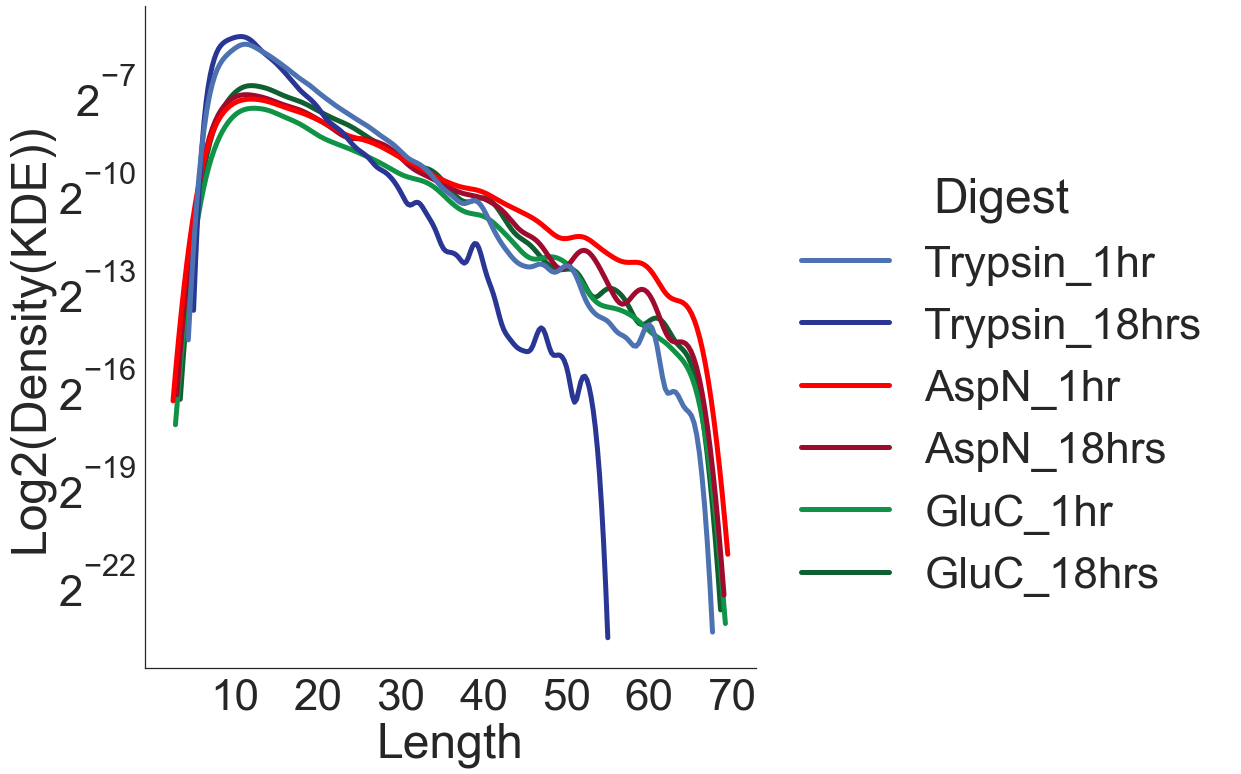

In [32]:
df1 = length.stack().reset_index()
df1.columns = ['Null','Digest','Length']
df1.drop(['Null'], axis=1, inplace=True)
df1
sns.set(font_scale = 4)
sns.set_style("white")

g=sns.displot(
    data=df1,
    x="Length", hue="Digest",
    kind="kde", height=12,log_scale=(0,2),palette=colors,linewidth=5  
)
plt.xticks([10,20,30,40,50,60,70])
plt.xlabel('Length', fontsize=48)
plt.ylabel('Log2(Density(KDE))', fontsize=48)
g.savefig("Length.eps")

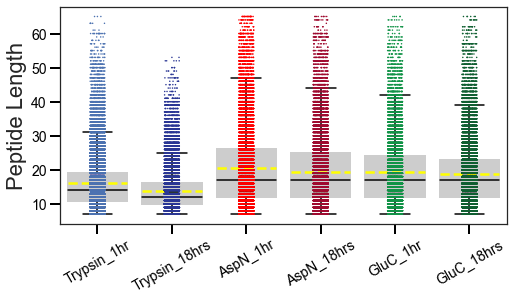

In [33]:
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style("ticks")
meanlineprops = dict(linestyle='--', linewidth=2.5, color='yellow')
boxprops = dict( linestyle='-',linewidth=2, color='#CDCDCD')
plt.tick_params(axis='x', colors='black', length=10, width=2)
plt.tick_params(axis='y', colors='black', length=10, width=2)
sns.stripplot(data=length,palette=colors,s=1.5)
sns.boxplot(data=length,showmeans=True, meanline=True,
            boxprops=boxprops,meanprops=meanlineprops,showfliers=False,color="black")
# plt.title('Sequence Coverage of All Proteins',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.ylabel("Peptide Length",fontsize=22)
plt.xticks(fontsize=14,rotation=30)
plt.yticks(fontsize=14)
# plt.axhline(y=0.3, linestyle="--",color='black',linewidth=2)
# plt.axhline(y=-0.4, linestyle="--",color='black',linewidth=2)
plt.savefig('Peptide_Length',format=fmt,dpi=dpi,bbox_inches="tight")
plt.show()

#### Charge

In [34]:
#Charge of Peptides
x=[T1_pep_z,T18_pep_z,A1_pep_z,A18_pep_z,G1_pep_z,G18_pep_z]
charge=pd.concat([i for i in x], axis=1)
charge.columns = ['Trypsin_1hr', 'Trypsin_18hrs','AspN_1hr','AspN_18hrs','GluC_1hr','GluC_18hrs']
charge

,Trypsin_1hr,Trypsin_18hrs,AspN_1hr,AspN_18hrs,GluC_1hr,GluC_18hrs
0,2,2.0,5.0,5.0,5.0,5.0
1,2,2.0,6.0,6.0,2.0,5.0
2,2,2.0,5.0,5.0,4.0,2.0
3,4,4.0,4.0,4.0,3.0,4.0
4,4,3.0,5.0,4.0,2.0,3.0
...,...,...,...,...,...,...
48150,4,NaN,NaN,NaN,NaN,NaN
48151,2,NaN,NaN,NaN,NaN,NaN
48152,3,NaN,NaN,NaN,NaN,NaN
48153,2,NaN,NaN,NaN,NaN,NaN


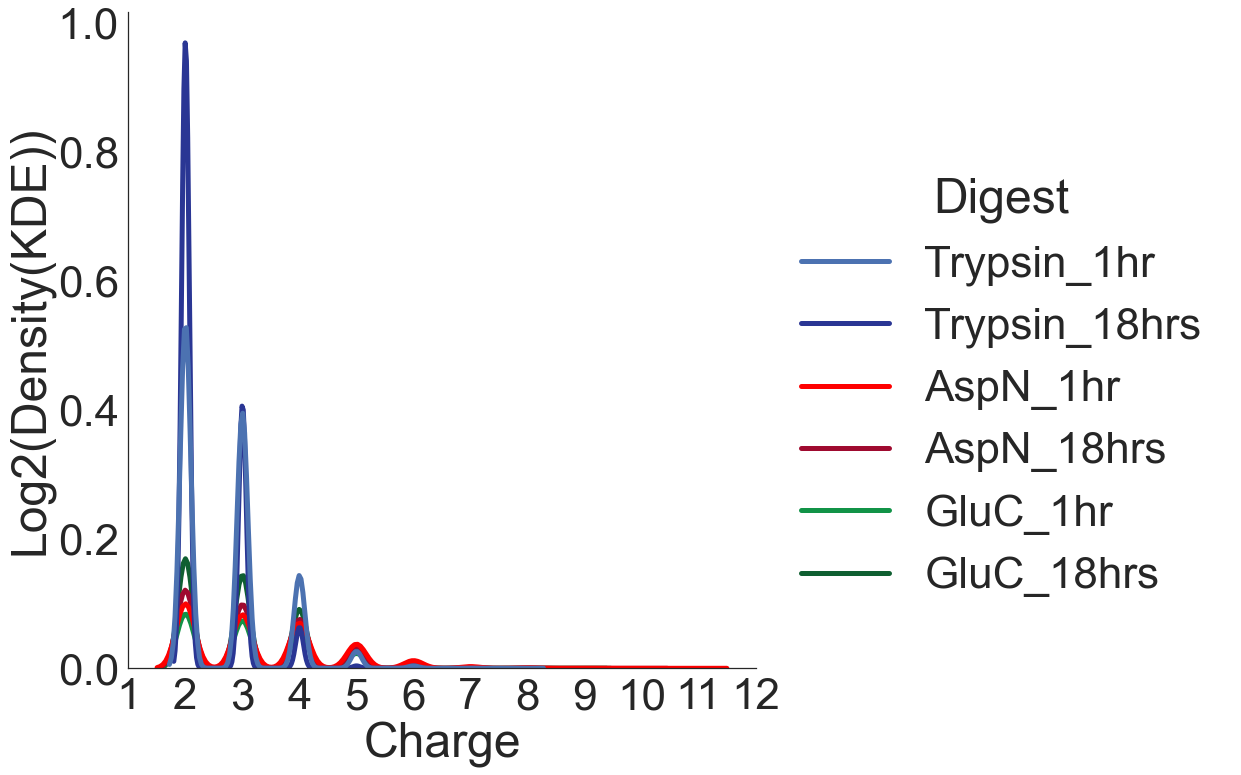

In [35]:
df1 = charge.stack().reset_index()
df1.columns = ['Null','Digest','Charge']
df1.drop(['Null'], axis=1, inplace=True)
df1
sns.set(font_scale = 4)
sns.set_style("white")

g=sns.displot(
    data=df1,
    x="Charge", hue="Digest",
    kind="kde", height=12,log_scale=(0,0),palette=colors,linewidth=5  
)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.xlabel('Charge', fontsize=48)
plt.ylabel('Log2(Density(KDE))', fontsize=48)
g.savefig("Charge.eps")

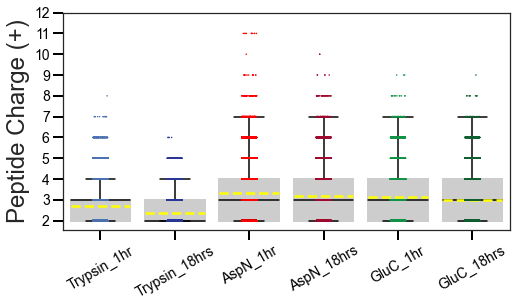

In [36]:
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style("ticks")
meanlineprops = dict(linestyle='--', linewidth=2.5, color='yellow')
boxprops = dict( linestyle='-',linewidth=2, color='#CDCDCD')
plt.tick_params(axis='x', colors='black', length=10, width=2)
plt.tick_params(axis='y', colors='black', length=10, width=2)
sns.stripplot(data=charge,palette=colors,s=1.5)
sns.boxplot(data=charge,showmeans=True, meanline=True,
            boxprops=boxprops,meanprops=meanlineprops,showfliers=False,color="black")
# plt.title('Sequence Coverage of All Proteins',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.ylabel("Peptide Charge (+)",fontsize=24)
plt.xticks(fontsize=14,rotation=30)
plt.yticks(np.arange(2,13,1),fontsize=14)
# plt.axhline(y=0.3, linestyle="--",color='black',linewidth=2)
# plt.axhline(y=-0.4, linestyle="--",color='black',linewidth=2)
# plt.savefig('Peptide_Charge',format=fmt,dpi=dpi,bbox_inches="tight")
plt.show()

#### Mass

In [37]:
#Mass of Peptides
x=[T1_pep_Mass,T18_pep_Mass,A1_pep_Mass,A18_pep_Mass,G1_pep_Mass,G18_pep_Mass]
Mass=pd.concat([i for i in x], axis=1)
Mass.columns = ['Trypsin_1hr', 'Trypsin_18hrs','AspN_1hr','AspN_18hrs','GluC_1hr','GluC_18hrs']
Mass

,Trypsin_1hr,Trypsin_18hrs,AspN_1hr,AspN_18hrs,GluC_1hr,GluC_18hrs
0,2254.9514,2254.9514,4741.4175,4741.4175,2822.4175,2822.4175
1,2175.9377,2175.9377,4740.4336,4740.4336,1706.8839,2823.4016
2,2014.0371,2014.0371,5422.6704,5422.6704,2564.2336,1706.8839
3,1781.9424,1781.9424,3667.7795,3667.7795,3073.4670,2564.2336
4,4708.3159,1910.0374,5423.6548,4001.8806,2073.0166,3073.4670
...,...,...,...,...,...,...
48150,2099.9768,NaN,NaN,NaN,NaN,NaN
48151,1536.8259,NaN,NaN,NaN,NaN,NaN
48152,1638.9491,NaN,NaN,NaN,NaN,NaN
48153,846.4235,NaN,NaN,NaN,NaN,NaN


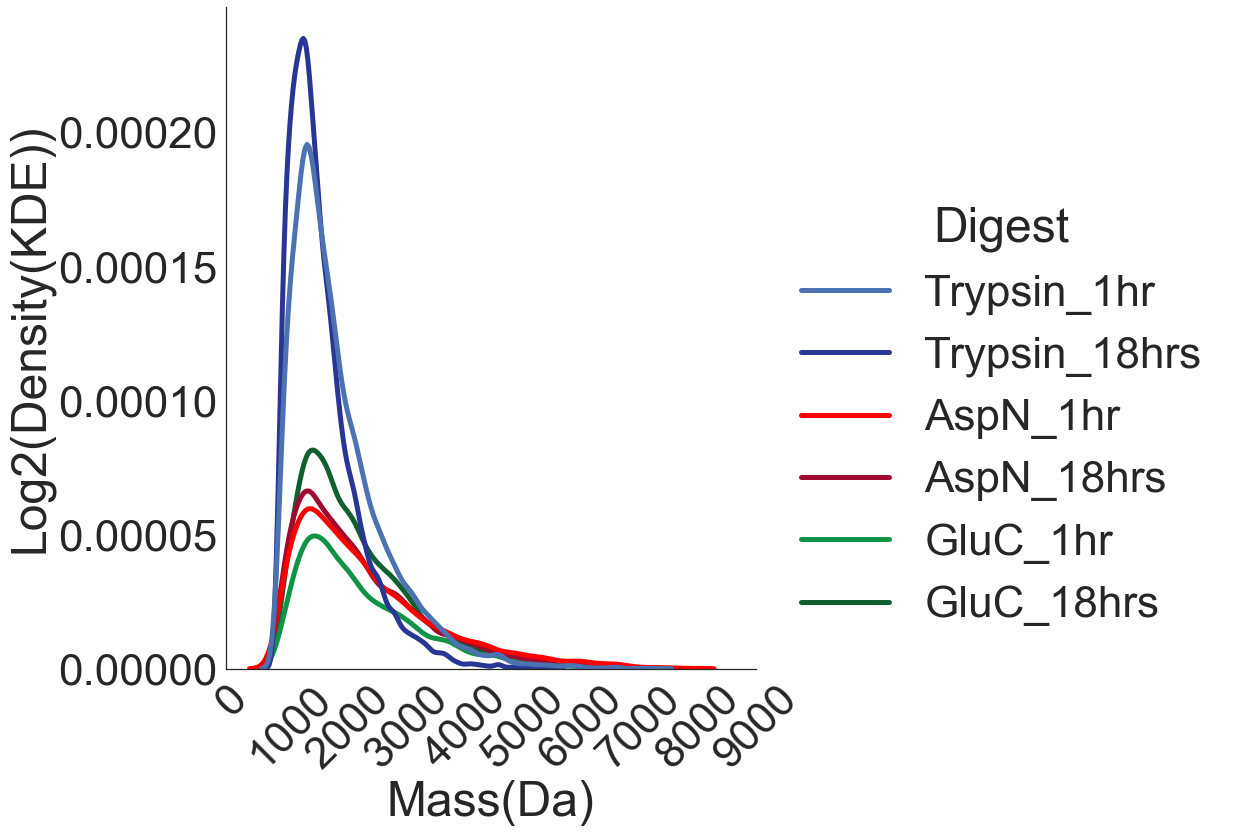

In [38]:
df1 = Mass.stack().reset_index()
df1.columns = ['Null','Digest','Mass']
df1.drop(['Null'], axis=1, inplace=True)
df1
sns.set(font_scale = 4)
sns.set_style("white")

g=sns.displot(
    data=df1,
    x="Mass", hue="Digest",
    kind="kde", height=12,log_scale=(0,0),palette=colors,linewidth=5  
)
plt.xticks(np.arange(0,10000,1000),rotation=45)
plt.xlabel('Mass(Da)', fontsize=48)
plt.ylabel('Log2(Density(KDE))', fontsize=48)
g.savefig("Mass.eps")

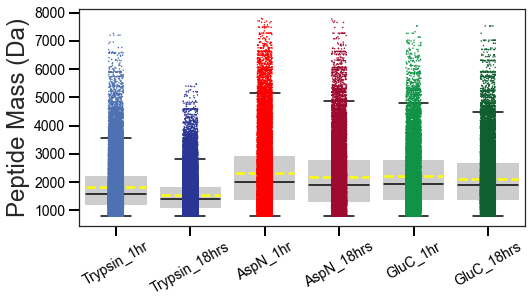

In [39]:
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style("ticks")
meanlineprops = dict(linestyle='--', linewidth=2.5, color='yellow')
boxprops = dict( linestyle='-',linewidth=2, color='#CDCDCD')
plt.tick_params(axis='x', colors='black', length=10, width=2)
plt.tick_params(axis='y', colors='black', length=10, width=2)
sns.stripplot(data=Mass,palette=colors,s=1.5)
sns.boxplot(data=Mass,showmeans=True, meanline=True,
            boxprops=boxprops,meanprops=meanlineprops,showfliers=False,color="black")
# plt.title('Sequence Coverage of All Proteins',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.ylabel("Peptide Mass (Da)",fontsize=24)
plt.xticks(fontsize=14,rotation=30)
plt.yticks(np.arange(1000,9000,1000),fontsize=14)
# plt.axhline(y=0.3, linestyle="--",color='black',linewidth=2)
# plt.axhline(y=-0.4, linestyle="--",color='black',linewidth=2)
# plt.savefig('Peptide_Mass',format=fmt,dpi=dpi,bbox_inches="tight")
plt.show()

#### Mass/Charge Ratio

In [40]:

#Mass of Peptides
x=[T1_pep_mz,T18_pep_mz,A1_pep_mz,A18_pep_mz,G1_pep_mz,G18_pep_mz]
mz=pd.concat([i for i in x], axis=1)
mz.columns = ['Trypsin_1hr', 'Trypsin_18hrs','AspN_1hr','AspN_18hrs','GluC_1hr','GluC_18hrs']
mz

,Trypsin_1hr,Trypsin_18hrs,AspN_1hr,AspN_18hrs,GluC_1hr,GluC_18hrs
0,1128.4834,1128.4834,949.2921,949.2921,565.4911,565.4911
1,1088.9771,1088.9771,791.0785,791.0785,854.4487,565.6885
2,1008.0255,1008.0255,1085.5408,1085.5408,642.0662,854.4487
3,446.4927,446.4927,917.9521,917.9521,1025.4990,642.0662
4,1178.0920,637.6861,1085.7463,1001.4797,1037.5146,1025.4990
...,...,...,...,...,...,...
48150,526.0063,NaN,NaN,NaN,NaN,NaN
48151,769.4198,NaN,NaN,NaN,NaN,NaN
48152,547.3246,NaN,NaN,NaN,NaN,NaN
48153,424.2243,NaN,NaN,NaN,NaN,NaN


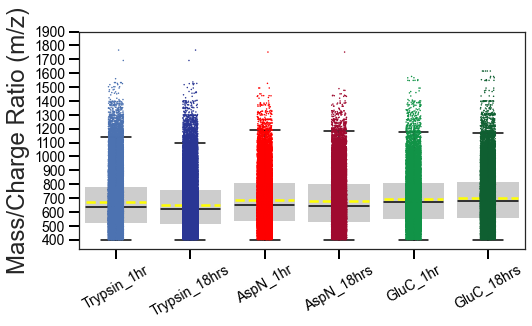

In [41]:
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style("ticks")
meanlineprops = dict(linestyle='--', linewidth=2.5, color='yellow')
boxprops = dict( linestyle='-',linewidth=2, color='#CDCDCD')
plt.tick_params(axis='x', colors='black', length=10, width=2)
plt.tick_params(axis='y', colors='black', length=10, width=2)
sns.stripplot(data=mz,palette=colors,s=1.5)
sns.boxplot(data=mz,showmeans=True, meanline=True,
            boxprops=boxprops,meanprops=meanlineprops,showfliers=False,color="black")
# plt.title('Sequence Coverage of All Proteins',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.ylabel("Mass/Charge Ratio (m/z)",fontsize=24)
plt.xticks(fontsize=14,rotation=30)
plt.yticks(np.arange(400,2000,100),fontsize=14)
# plt.axhline(y=0.3, linestyle="--",color='black',linewidth=2)
# plt.axhline(y=-0.4, linestyle="--",color='black',linewidth=2)
# plt.savefig('Peptide_MassCharge',format=fmt,dpi=dpi,bbox_inches="tight")
plt.show()

#### Hydrophobicity

In [42]:
#GRAVY of Peptides
x=[T1_pep_Hydro_Sum,T18_pep_Hydro_Sum,A1_pep_Hydro_Sum,A18_pep_Hydro_Sum,G1_pep_Hydro_Sum,G18_pep_Hydro_Sum]
GRAVY=pd.concat([i for i in x], axis=1)
GRAVY.columns = ['Trypsin_1hr', 'Trypsin_18hrs','AspN_1hr','AspN_18hrs','GluC_1hr','GluC_18hrs']
GRAVY

,Trypsin_1hr,Trypsin_18hrs,AspN_1hr,AspN_18hrs,GluC_1hr,GluC_18hrs
0,-1.066667,-1.066667,-0.278571,-0.278571,-0.460000,-0.460000
1,-1.085714,-1.085714,-0.278571,-0.278571,-0.368750,-0.460000
2,-1.117647,-1.117647,-0.140816,-0.140816,-0.600000,-0.368750
3,-0.718750,-0.718750,-0.887879,-0.887879,0.017857,-0.600000
4,-0.200000,-0.905882,-0.140816,-1.661765,-0.933333,0.017857
...,...,...,...,...,...,...
48150,-0.147368,NaN,NaN,NaN,NaN,NaN
48151,-0.633333,NaN,NaN,NaN,NaN,NaN
48152,1.282353,NaN,NaN,NaN,NaN,NaN
48153,-1.544444,NaN,NaN,NaN,NaN,NaN


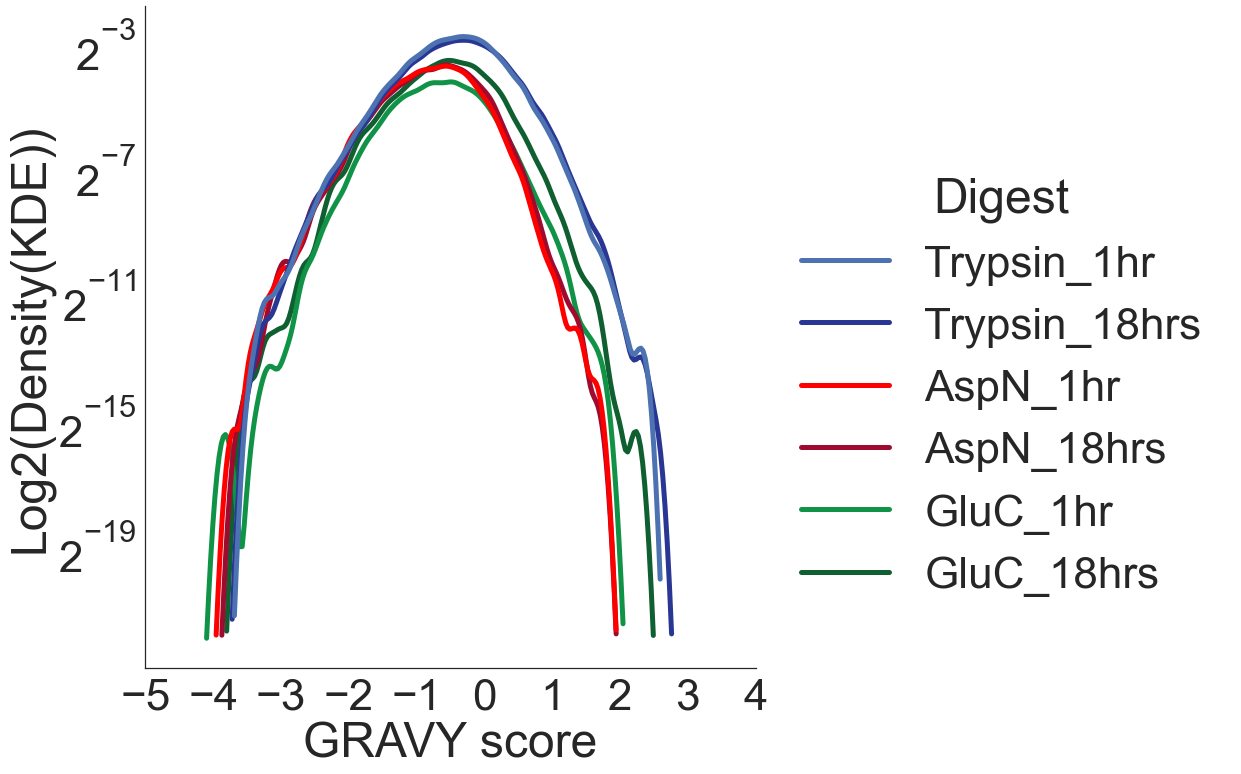

In [43]:
df1 = GRAVY.stack().reset_index()
df1.columns = ['Null','Digest','GRAVY']
df1.drop(['Null'], axis=1, inplace=True)
df1
sns.set(font_scale = 4)
sns.set_style("white")

g=sns.displot(
    data=df1,
    x="GRAVY", hue="Digest",
    kind="kde", height=12,log_scale=(0,2),palette=colors,linewidth=5  
)
plt.xticks(np.arange(-5,5,1))
plt.xlabel('GRAVY score', fontsize=48)
plt.ylabel('Log2(Density(KDE))', fontsize=48)
g.savefig("GRAVY.eps")

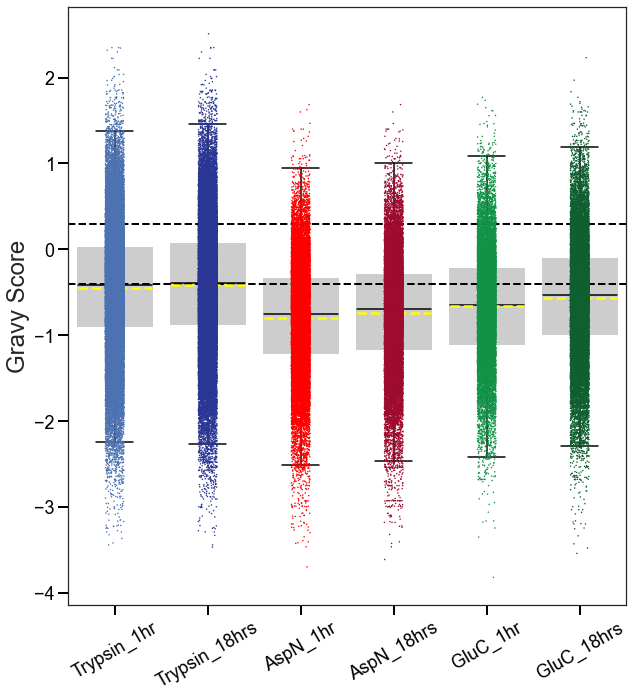

In [45]:
sns.set(rc={'figure.figsize':(10,11)})
sns.set_style("ticks")
meanlineprops = dict(linestyle='--', linewidth=2.5, color='yellow')
boxprops = dict( linestyle='-',linewidth=2, color='#CDCDCD')
plt.tick_params(axis='x', colors='black', length=10, width=2)
plt.tick_params(axis='y', colors='black', length=10, width=2)
sns.stripplot(data=GRAVY,palette=colors,s=1.5)
sns.boxplot(data=GRAVY,showmeans=True, meanline=True,
            boxprops=boxprops,meanprops=meanlineprops,showfliers=False,color="black")
# plt.title('Sequence Coverage of All Proteins',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.ylabel("Gravy Score",fontsize=24)
plt.xticks(fontsize=18,rotation=30)
plt.yticks(fontsize=18)
plt.axhline(y=0.3, linestyle="--",color='black',linewidth=2)
plt.axhline(y=-0.4, linestyle="--",color='black',linewidth=2)
# plt.savefig('Hydro_Box',format=fmt,dpi=dpi,bbox_inches="tight")
plt.show()

## Grouped Peptide Analyses

In [46]:
og_pep.groupby(['Protein']).size().reset_index(name='counts')

,Protein,counts
0,A0A0B4J2D5,43
1,A0A0B4J2F0,2
2,A0A1B0GU29,1
3,A0A1B0GUS4,53
4,A0A1B0GWK0,1
...,...,...
5156,Q9Y6X3,6
5157,Q9Y6X9,2
5158,Q9Y6Y0,3
5159,Q9Y6Y8,8


### Grouping by Protein Identification (# of Peptides per Protein)

In [47]:
grouping = ['Protein']

T18_Counts=T18_50_pep.groupby(grouping).size().reset_index(name='counts')
T1_Counts=T1_50_pep.groupby(grouping).size().reset_index(name='counts')
A18_Counts=A18_50_pep.groupby(grouping).size().reset_index(name='counts')
A1_Counts=A1_50_pep.groupby(grouping).size().reset_index(name='counts')
G18_Counts=G18_50_pep.groupby(grouping).size().reset_index(name='counts')
G1_Counts=G1_50_pep.groupby(grouping).size().reset_index(name='counts')
# counts=pd.concat([T18_Counts, T1_Counts,A18_Counts,A1_Counts,G18_Counts,G1_Counts],axis=1)
# counts.columns=['T18','T18_Counts','T1','T1_Counts','A18','A18_Counts','A1','A1_Counts','G18','G18_Counts','G1','G1_Counts']
# counts = counts.sort_values(by ='G1_Counts', ascending=False )
T18_Counts

,Protein,counts
0,A0A0B4J2D5,9
1,A0A0B4J2F0,1
2,A0A1B0GUS4,14
3,A0AVT1,33
4,A0FGR8,3
...,...,...
4196,Q9Y6W5,5
4197,Q9Y6X3,2
4198,Q9Y6X9,1
4199,Q9Y6Y0,2


### Trypsin 18 hours, Counting protiens with > or < 1 peptide IDs

In [48]:
T18_grouped=T18_50_pep.groupby(['Protein'], as_index=False).mean()
T18_50_pop=pd.merge(T18_grouped, T18_Counts, on="Protein")
T18_x2 = T18_50_pop.loc[(T18_50_pop['counts']) > 1]
T18_x3 = T18_50_pop.loc[(T18_50_pop['counts']) == 1]
T18_x4=(len(T18_x3)/len(T18_x2))*100 
print(" The Number of Proteins with greater than 1 peptide detected is:")
print(len(T18_x2))
print(" The Number of Proteins with only 1 peptide detected is:")
print(len(T18_x3))
print("The Ratio is:")
print(T18_x4)
T18_x2

 The Number of Proteins with greater than 1 peptide detected is:
3456
 The Number of Proteins with only 1 peptide detected is:
745
The Ratio is:
21.556712962962962


,Protein,Area Tryp_18hr_1:50_Rep1,Area Trypsin_18hr_1:50_Rep2,#Feature Tryp_18hr_1:50_Rep1,#Feature Trypsin_18hr_1:50_Rep2,Protein ID,Mass,RT,Score (%),m/z,z,Length,IPC,Hydro_Sum,Neutral_Z,counts
0,A0A0B4J2D5,5.265547e+07,1.190207e+07,1.000000,0.555556,1531.0,1813.034467,135.308889,99.533333,631.090211,2.777778,17.111111,6.855496,-0.079744,-0.222222,9
2,A0A1B0GUS4,2.461900e+08,8.043314e+06,1.428571,0.142857,2478.0,2165.191043,185.827857,99.842857,808.472679,2.714286,19.142857,5.571309,-0.408880,-1.142857,14
3,A0AVT1,2.687987e+07,1.301127e+07,0.787879,0.787879,677.0,1496.997055,132.290303,99.890909,614.522612,2.454545,13.030303,7.081155,-0.143922,0.000000,33
4,A0FGR8,0.000000e+00,3.953000e+06,0.000000,1.000000,3338.0,1216.668000,100.320000,99.366667,531.689600,2.333333,11.000000,5.458200,0.037802,-0.666667,3
5,A0MZ66,5.553889e+06,3.917011e+06,0.333333,0.777778,1305.0,1235.652067,116.168889,99.422222,563.284544,2.222222,10.666667,5.729237,-0.253093,-1.000000,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4195,Q9Y6W3,3.809225e+06,6.541750e+05,0.750000,0.250000,3685.0,1210.649800,113.940000,98.950000,546.137875,2.250000,10.250000,7.160405,-0.347235,0.000000,4
4196,Q9Y6W5,1.181494e+07,2.948100e+06,0.800000,0.400000,1748.0,1438.300280,159.812000,99.880000,647.523580,2.200000,12.400000,6.663768,-0.442381,-0.800000,5
4197,Q9Y6X3,7.918400e+06,0.000000e+00,1.000000,0.000000,3284.0,1257.203300,164.110000,98.900000,500.201150,2.500000,10.500000,8.909141,0.071111,0.500000,2
4199,Q9Y6Y0,4.343750e+06,0.000000e+00,1.000000,0.000000,3750.0,1844.866450,142.805000,99.700000,628.432100,3.000000,15.000000,9.099316,-0.413690,1.000000,2


### Trypsin 1 hour, Counting protiens with > or < 1 peptide IDs

In [49]:
T1_grouped=T18_50_pep.groupby(['Protein'], as_index=False).mean()
T1_50_pop=pd.merge(T1_grouped, T1_Counts, on="Protein")
T1_x2 = T1_50_pop.loc[(T1_50_pop['counts']) > 1]
T1_x3 = T1_50_pop.loc[(T1_50_pop['counts']) == 1]
T1_x4=len(T1_x3)/len(T1_x2)*100 
print(" The Number of Proteins with greater than 1 peptide detected is:")
print(len(T1_x2))
print(" The Number of Proteins with only 1 peptide detected is:")
print(len(T1_x3))
print("The Ratio is:")
print(T1_x4)

 The Number of Proteins with greater than 1 peptide detected is:
3180
 The Number of Proteins with only 1 peptide detected is:
498
The Ratio is:
15.660377358490566


### AspN 18 hours, Counting protiens with > or < 1 peptide IDs

In [50]:
A18_grouped=A18_50_pep.groupby(['Protein'], as_index=False).mean()
A18_50_pop=pd.merge(A18_grouped, A18_Counts, on="Protein")
A18_x2 = A18_50_pop.loc[(A18_50_pop['counts']) > 1]
A18_x3 = A18_50_pop.loc[(A18_50_pop['counts']) == 1]
A18_x4=len(A18_x3)/len(A18_x2)*100 
print(" The Number of Proteins with greater than 1 peptide detected is:")
print(len(A18_x2))
print(" The Number of Proteins with only 1 peptide detected is:")
print(len(A18_x3))
print("The Ratio is:")
print(A18_x4)

 The Number of Proteins with greater than 1 peptide detected is:
2360
 The Number of Proteins with only 1 peptide detected is:
880
The Ratio is:
37.28813559322034


###  AspN 1 hours, Counting protiens with > or < 1 peptide IDs

In [51]:
A1_grouped=A1_50_pep.groupby(['Protein'], as_index=False).mean()
A1_50_pop=pd.merge(A1_grouped, A1_Counts, on="Protein")
A1_x2 = A1_50_pop.loc[(A1_50_pop['counts']) > 1]
A1_x3 = A1_50_pop.loc[(A1_50_pop['counts']) == 1]
A1_x4=len(A1_x3)/len(A1_x2)*100 
print(" The Number of Proteins with greater than 1 peptide detected is:")
print(len(A1_x2))
print(" The Number of Proteins with only 1 peptide detected is:")
print(len(A1_x3))
print("The Ratio is:")
print(A1_x4)

 The Number of Proteins with greater than 1 peptide detected is:
2601
 The Number of Proteins with only 1 peptide detected is:
953
The Ratio is:
36.639753940792005


### GluC 18 hours, Counting protiens with > or < 1 peptide IDs

In [52]:
G18_grouped=G18_50_pep.groupby(['Protein'], as_index=False).mean()
G18_50_pop=pd.merge(G18_grouped, G18_Counts, on="Protein")
G18_x2 = G18_50_pop.loc[(G18_50_pop['counts']) > 1]
G18_x3 = G18_50_pop.loc[(G18_50_pop['counts']) == 1]
G18_x4=len(G18_x3)/len(G18_x2)*100 
print(" The Number of Proteins with greater than 1 peptide detected is:")
print(len(G18_x2))
print(" The Number of Proteins with only 1 peptide detected is:")
print(len(G18_x3))
print("The Ratio is:")
print(G18_x4)

 The Number of Proteins with greater than 1 peptide detected is:
2246
 The Number of Proteins with only 1 peptide detected is:
729
The Ratio is:
32.457702582368654


### GluC 1 hours, Counting protiens with > or < 1 peptide IDs 

In [53]:
G1_grouped=G1_50_pep.groupby(['Protein'], as_index=False).mean()
G1_50_pop=pd.merge(G1_grouped, G1_Counts, on="Protein")
G1_x2 = G1_50_pop.loc[(G1_50_pop['counts']) > 1]
G1_x3 = G1_50_pop.loc[(G1_50_pop['counts']) == 1]
G1_x4=len(G1_x3)/len(G1_x2)*100 
print(" The Number of Proteins with greater than 1 peptide detected is:")
print(len(G1_x2))
print(" The Number of Proteins with only 1 peptide detected is:")
print(len(G1_x3))
print("The Ratio is:")
print(G1_x4)

 The Number of Proteins with greater than 1 peptide detected is:
1733
 The Number of Proteins with only 1 peptide detected is:
745
The Ratio is:
42.98903635314484


### Peptide per Protein Stacked Bar Graph

In [54]:
df = pd.DataFrame(columns=["Group","Trypsin 18hrs","Trypsin 1hr", "AspN 18hrs","AspN 1hr",
                           "GluC 18hrs","GluC 1hr",], 
                  data=[["= 1 Peptide",T18_x4,T1_x4,A18_x4,A1_x4,G18_x4,G1_x4],
                        ["> 1 Peptide",100-T18_x4,100-T1_x4,100-A18_x4,100-A1_x4,100-G18_x4,100-G1_x4],
])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


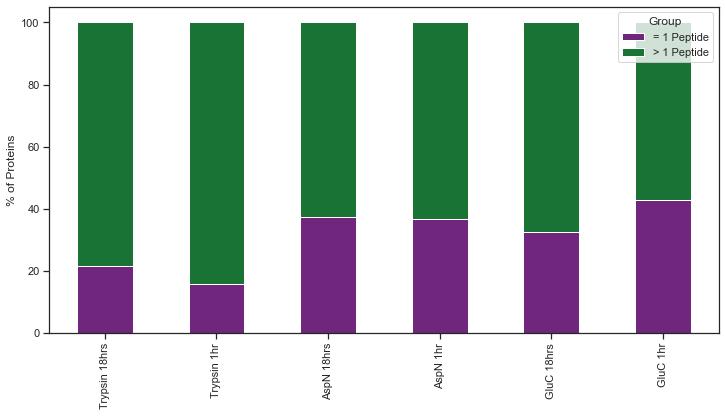

In [55]:
from matplotlib.colors import ListedColormap

df.set_index('Group')\
  .reindex(df.set_index('Group').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("PRGn", 10)), 
          figsize=(12,6))
plt.ylabel("% of Proteins")
plt.savefig('Stacked_Peptide_per_Protein',format=fmt,dpi=dpi,bbox_inches="tight")

### Peptide Feature vs Peptide IDs/Protein

#### Proteins with >2 peptides detected

In [61]:
list_of_lists=[]
labels=["T18_up","T1_up","A18_up","A1_up","G18_up","G1_up"]
proteins=[T18_x2,T1_x2,A18_x2,A1_x2,G18_x2,G1_x2]
datafames=[T18_50_pep,T1_50_pep,A18_50_pep,A1_50_pep,G18_50_pep,G1_50_pep]

for dataframe,protein,label in zip(dataframes,proteins,labels):
    y2=protein['Protein'].astype(str).values.tolist()
    globals()[str(label)]=dataframe[dataframe["Protein"].isin(y2)]

T_18net=T18_up.Protein
%store net

Stored 'net' (Series)


0        P08238
1        P08238
2        P08238
3        P08238
4        P08238
          ...  
47981    P00846
47992    O75925
48000    Q96H55
48006    Q71SY5
48015    Q8N4H5
Name: Protein, Length: 47240, dtype: object

In [ ]:
grab="IPC"
xx=[T18_up[grab],T1_up[grab],A18_up[grab],A1_up[grab],G18_up[grab],G1_up[grab]]
IPC=pd.concat([i for i in xx], axis=1)
IPC.columns = ['Trypsin_18hrs', 'Trypsin_1hr','AspN_18hrs','AspN_1hr','GluC_18hrs','GluC_1hr']
df1 = IPC.stack().reset_index()
df1.columns = ['Null','Digest','IPC']
df1.drop(['Null'], axis=1, inplace=True)
sns.set(font_scale = 4)
sns.set_style("white")
g=sns.displot(
    data=df1,
    x="IPC", hue="Digest",
    kind="kde", height=15,log_scale=(0,2),palette=colors,
    
)
plt.xlabel('Isoelectric Point(IPC)', fontsize=48)
plt.ylabel('Density(KDE)', fontsize=48)
plt.title('Hydrophobicity of Peptides for Proteins >2 Peptides',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.savefig('IPC_Kernel Density_over2peptides',format=fmt,dpi=dpi,bbox_inches="tight")

In [ ]:

grab="Hydro_Sum"
xx=[T18_up[grab],T1_up[grab],A18_up[grab],A1_up[grab],G18_up[grab],G1_up[grab]]
GRAVY=pd.concat([i for i in xx], axis=1)
GRAVY.columns = ['Trypsin_18hrs', 'Trypsin_1hr','AspN_18hrs','AspN_1hr','GluC_18hrs','GluC_1hr']
df1 = GRAVY.stack().reset_index()
df1.columns = ['Null','Digest','GRAVY']
df1.drop(['Null'], axis=1, inplace=True)
sns.set(font_scale = 4)
sns.set_style("white")
g=sns.displot(
    data=df1,
    x="GRAVY", hue="Digest",
    kind="kde", height=15,log_scale=(0,2),palette=colors,
    
)
plt.xlabel('GRAVY Score', fontsize=48)
plt.ylabel('Density(KDE)', fontsize=48)
plt.xticks(np.arange(-4,5,1))
plt.title('Hydrophobicity of Peptides for Proteins >2 Peptides',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.savefig('GRAVY_Kernel Density_over2peptides',format=fmt,dpi=dpi,bbox_inches="tight")

#### Proteins with <2 peptides detected

In [ ]:
list_of_lists=[]
labels=["T18_down","T1_down","A18_down","A1_down","G18_down","G1_down"]
proteins=[T18_x3,T1_x3,A18_x3,A1_x3,G18_x3,G1_x3]
datafames=[T18_50_pep,T1_50_pep,A18_50_pep,A1_50_pep,G18_50_pep,G1_50_pep]

for dataframe,protein,label in zip(dataframes,proteins,labels):
    y2=protein['Protein'].astype(str).values.tolist()
    globals()[str(label)]=dataframe[dataframe["Protein"].isin(y2)]

T18_down

In [ ]:
grab="IPC"
xx=[T18_down[grab],T1_down[grab],A18_down[grab],A1_down[grab],G18_down[grab],G1_down[grab]]
IPC=pd.concat([i for i in xx], axis=1)
IPC.columns = ['Trypsin_18hrs', 'Trypsin_1hr','AspN_18hrs','AspN_1hr','GluC_18hrs','GluC_1hr']
df1 = IPC.stack().reset_index()
df1.columns = ['Null','Digest','IPC']
df1.drop(['Null'], axis=1, inplace=True)
sns.set(font_scale = 4)
sns.set_style("white")
g=sns.displot(
    data=df1,
    x="IPC", hue="Digest",
    kind="kde", height=15,log_scale=(0,2),palette=colors,
    
)
plt.xlabel('Isoelectric Point(IPC)', fontsize=48)
plt.ylabel('Density(KDE)', fontsize=48)
plt.title('Hydrophobicity of Peptides for Proteins >2 Peptides',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.savefig('IPC_Kernel Density_under2peptides',format=fmt,dpi=dpi,bbox_inches="tight")

In [ ]:
grab="Hydro_Sum"
xx=[T18_down[grab],T1_down[grab],A18_down[grab],A1_down[grab],G18_down[grab],G1_down[grab]]
IPC=pd.concat([i for i in xx], axis=1)
IPC.columns = ['Trypsin_18hrs', 'Trypsin_1hr','AspN_18hrs','AspN_1hr','GluC_18hrs','GluC_1hr']
df1 = IPC.stack().reset_index()
df1.columns = ['Null','Digest','IPC']
df1.drop(['Null'], axis=1, inplace=True)
sns.set(font_scale = 4)
sns.set_style("white")
g=sns.displot(
    data=df1,
    x="IPC", hue="Digest",
    kind="kde", height=15,log_scale=(0,2),palette=colors,
    
)
plt.xlabel('GRAVY Score', fontsize=48)
plt.ylabel('Density(KDE)', fontsize=48)
plt.xticks(np.arange(-4,5,1))
# plt.title('Hydrophobicity of Peptides for Proteins >2 Peptides',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.savefig('GRAVY_Kernel Density_under2peptides',format=fmt,dpi=dpi,bbox_inches="tight")

In [ ]:
# stop=stop

# Analysis of Proteins Only

In [ ]:
og = pd.read_csv("proteins_1in50only.csv")
og[['Protein', 'Gene']] = og['Accession'].str.split('|', 1, expand=True)
len(og)

In [ ]:
og_info=og[['Protein ID','Protein', 'Gene','Avg. Mass','Score (%)','-10lgP','Coverage (%)','#Peptides']]

## Trypsin Protein Analyses

In [ ]:
Tryp=og.loc[:, og.columns.str.contains('Tryp')]
Tryp = pd.concat([og_info, Tryp], axis=1)
#Tryp.to_excel('AspN_50only.xlsx')
Tryp.describe()

In [ ]:
y=str('18hr')
Tryp18_50_pro=Tryp.loc[:, Tryp.columns.str.contains(y)]
Tryp18_50_pro = pd.concat([og_info, Tryp18_50_pro], axis=1)
Tryp18_50_pro=Tryp18_50_pro.loc[(Tryp18_50_pro['#Spec Tryp_18hr_1:50_Rep1'] > 0) | (Tryp18_50_pro['#Spec Trypsin_18hr_1:50_Rep2'] > 0)]
Tryp18_50_pro.to_excel('Tryp_' + y +'_proteins.xlsx')
Tryp18_50_pro.describe()

In [ ]:
Tryp18_50_pro['AvgCoverage'] = Tryp18_50_pro[['Coverage (%) Tryp_18hr_1:50_Rep1','Coverage (%) Trypsin_18hr_1:50_Rep2']].mean(axis=1)
Tryp18_50_pro['MaxCoverage'] = Tryp18_50_pro[['Coverage (%) Tryp_18hr_1:50_Rep1','Coverage (%) Trypsin_18hr_1:50_Rep2']].max(axis=1)
Tryp18_50_coverage=Tryp18_50_pro.loc[(Tryp18_50_pro['AvgCoverage']>0)]
Tryp18_50_coverage.describe()

In [ ]:
Tryp18_50_coverage.median()

In [ ]:
y=str('1hr')
Tryp1_50_pro=Tryp.loc[:, Tryp.columns.str.contains(y)]
Tryp1_50_pro = pd.concat([og_info, Tryp1_50_pro], axis=1)
Tryp1_50_pro=Tryp1_50_pro.loc[(Tryp1_50_pro['#Spec Tryp_1hr_1:50_Rep1'] > 0) | (Tryp1_50_pro['#Spec Tryp_1hr_1:50_Rep2'] > 0)]
Tryp1_50_pro.to_excel('Tryp_' + y +'_proteins.xlsx')
Tryp1_50_pro.describe()

In [ ]:
Tryp1_50_pro['AvgCoverage'] = Tryp1_50_pro[['Coverage (%) Tryp_1hr_1:50_Rep1','Coverage (%) Tryp_1hr_1:50_Rep2']].mean(axis=1)
Tryp1_50_pro['MaxCoverage'] = Tryp1_50_pro[['Coverage (%) Tryp_1hr_1:50_Rep1','Coverage (%) Tryp_1hr_1:50_Rep2']].max(axis=1)
Tryp1_50_coverage=Tryp1_50_pro.loc[(Tryp1_50_pro['AvgCoverage']>0)]
Tryp1_50_coverage.describe()

In [ ]:
Tryp1_50_coverage.median()

In [ ]:
common=len(list(set(Tryp18_50_coverage.Protein) & set(Tryp1_50_coverage.Protein)))
common

In [ ]:
unique=len(list(set(Tryp18_50_coverage.Protein) ^ set(Tryp1_50_coverage.Protein)))
unique

In [ ]:
Ratio=(unique/(common+unique))*100
Ratio

### Comparison of Time

In [ ]:
x=set(Tryp18_50_coverage.Gene)
x2=set(Tryp1_50_coverage.Gene)
vd2=venn2([x, x2],set_labels=('18hrs', '1hr'),set_colors=('darkblue', 'blue'), alpha = 0.4)
venn2_circles([x,x2], linestyle='-.', linewidth=4, color='black')
for text in vd2.set_labels:
 text.set_fontsize(18);
for text in vd2.subset_labels:
 text.set_fontsize(18)
plt.title('Trypsin Comparison of Time',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.show()

## AspN Protein Analyses

In [ ]:
AspN=og.loc[:, og.columns.str.contains('AspN')]
AspN = pd.concat([og_info, AspN], axis=1)
#AspN.to_excel('AspN_50only.xlsx')
AspN

In [ ]:
y=str('18hr')
AspN18_50_pro=AspN.loc[:, AspN.columns.str.contains(y)]
AspN18_50_pro = pd.concat([og_info, AspN18_50_pro], axis=1)
AspN18_50_pro=AspN18_50_pro.loc[(AspN18_50_pro['#Spec AspN_18hr_1:50_Rep1'] > 0) | (AspN18_50_pro['#Spec AspN_18hr_1:50_Rep2'] > 0)]
AspN18_50_pro.to_excel('AspN_' + y +'_proteins.xlsx')
AspN18_50_pro.describe()

In [ ]:
AspN18_50_pro['AvgCoverage'] = AspN18_50_pro[['Coverage (%) AspN_18hr_1:50_Rep1','Coverage (%) AspN_18hr_1:50_Rep2']].mean(axis=1)
AspN18_50_pro['MaxCoverage'] = AspN18_50_pro[['Coverage (%) AspN_18hr_1:50_Rep1','Coverage (%) AspN_18hr_1:50_Rep2']].max(axis=1)
AspN18_50_coverage=AspN18_50_pro.loc[(AspN18_50_pro['AvgCoverage']>0)]
AspN18_50_coverage.describe()

In [ ]:
AspN18_50_coverage.median()

In [ ]:
y=str('1hr')
AspN1_50_pro=AspN.loc[:, AspN.columns.str.contains(y)]
AspN1_50_pro = pd.concat([og_info, AspN1_50_pro], axis=1)
AspN1_50_pro=AspN1_50_pro.loc[(AspN1_50_pro['#Spec AspN_1hr_1:50_Rep1'] > 0) | (AspN1_50_pro['#Spec AspN_1hr_1:50_Rep2'] > 0)]
AspN1_50_pro.to_excel('AspN_' + y +'_proteins.xlsx')
AspN1_50_pro.describe()

In [ ]:
AspN1_50_pro['AvgCoverage'] = AspN1_50_pro[['Coverage (%) AspN_1hr_1:50_Rep1','Coverage (%) AspN_1hr_1:50_Rep2']].mean(axis=1)
AspN1_50_pro['MaxCoverage'] = AspN1_50_pro[['Coverage (%) AspN_1hr_1:50_Rep1','Coverage (%) AspN_1hr_1:50_Rep2']].max(axis=1)
AspN1_50_coverage=AspN1_50_pro.loc[(AspN1_50_pro['AvgCoverage']>0)]
AspN1_50_coverage.describe()

In [ ]:
AspN1_50_coverage.median()

In [ ]:
common=len(list(set(AspN18_50_coverage.Gene) & set(AspN1_50_coverage.Gene)))
common

In [ ]:
unique=len(list(set(AspN18_50_coverage.Gene) ^ set(AspN1_50_coverage.Gene)))
unique

In [ ]:
Ratio=(unique/(common+unique))*100
Ratio

### Comparison of Time

In [ ]:
x=set(AspN18_50_coverage.Gene)
x2=set(AspN1_50_coverage.Gene)
vd2=venn2([x, x2],set_labels=('18hrs', '1hr'),set_colors=('orange', 'darkgrey'), alpha = 0.8)
venn2_circles([x,x2], linestyle='-.', linewidth=4, color='black')
for text in vd2.set_labels:
 text.set_fontsize(18);
for text in vd2.subset_labels:
 text.set_fontsize(18)
plt.title('GluC Comparison of Time',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.show()

## GluC Protein Analyses

In [ ]:
GluC=og.loc[:, og.columns.str.contains('GluC')]
GluC = pd.concat([og_info, GluC], axis=1)
#AspN.to_excel('GluC_50only.xlsx')
GluC

In [ ]:
y=str('18hr')
GluC18_50_pro=GluC.loc[:, GluC.columns.str.contains(y)]
GluC18_50_pro = pd.concat([og_info, GluC18_50_pro], axis=1)
GluC18_50_pro=GluC18_50_pro.loc[(GluC18_50_pro['#Spec GluC_18hr_1:50_Rep1'] > 0) | (GluC18_50_pro['#Spec GluC_18hr_1:50_Rep2'] > 0)]
GluC18_50_pro.to_excel('GluC_' + y +'_proteins.xlsx')
GluC18_50_pro.describe()

In [ ]:
GluC18_50_pro['AvgCoverage'] = GluC18_50_pro[['Coverage (%) GluC_18hr_1:50_Rep1','Coverage (%) GluC_18hr_1:50_Rep2']].mean(axis=1)
GluC18_50_pro['MaxCoverage'] = GluC18_50_pro[['Coverage (%) GluC_18hr_1:50_Rep1','Coverage (%) GluC_18hr_1:50_Rep2']].max(axis=1)
GluC18_50_coverage=GluC18_50_pro.loc[(GluC18_50_pro['AvgCoverage']>0)]
GluC18_50_coverage.describe()

In [ ]:
GluC18_50_coverage.median()

In [ ]:
y=str('1hr')
GluC1_50_pro=GluC.loc[:, GluC.columns.str.contains(y)]
GluC1_50_pro = pd.concat([og_info, GluC1_50_pro], axis=1)
GluC1_50_pro=GluC1_50_pro.loc[(GluC1_50_pro['#Spec GluC_1hr_1:50_Rep1'] > 0) | (GluC1_50_pro['#Spec GluC_1hr_1:50_Rep2'] > 0)]
GluC1_50_pro.to_excel('GluC_' + y +'_proteins.xlsx')
GluC1_50_pro.describe()

In [ ]:
GluC1_50_pro['AvgCoverage'] = GluC1_50_pro[['Coverage (%) GluC_1hr_1:50_Rep1','Coverage (%) GluC_1hr_1:50_Rep2']].mean(axis=1)
GluC1_50_pro['MaxCoverage'] = GluC1_50_pro[['Coverage (%) GluC_1hr_1:50_Rep1','Coverage (%) GluC_1hr_1:50_Rep2']].max(axis=1)
GluC1_50_coverage=GluC1_50_pro.loc[(GluC1_50_pro['AvgCoverage']>0)]
GluC1_50_coverage

In [ ]:
GluC1_50_coverage.median()

In [ ]:
common=len(list(set(GluC18_50_coverage.Gene) & set(GluC1_50_coverage.Gene)))
common

In [ ]:
unique=len(list(set(GluC18_50_coverage.Gene) ^ set(GluC1_50_coverage.Gene)))
unique

In [ ]:
Ratio=(unique/(common+unique))*100
Ratio

### Comparison of Time

In [ ]:
x=set(GluC18_50_coverage.Gene)
x2=set(GluC1_50_coverage.Gene)
vd2=venn2([x, x2],set_labels=('18hrs', '1hr'),set_colors=('darkgreen', 'lightgreen'), alpha = 0.8)
venn2_circles([x,x2], linestyle='-.', linewidth=4, color='black')
for text in vd2.set_labels:
 text.set_fontsize(18);
for text in vd2.subset_labels:
 text.set_fontsize(18)
plt.title('GluC Comparison of Time',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.show()

## Protein List Comparisons

In [ ]:
milk=[set(Tryp18_50_coverage.Protein), set(AspN18_50_coverage.Protein), set(GluC18_50_coverage.Protein)]
cookies=set(Tryp1_50_coverage.Protein) | set(GluC1_50_coverage.Protein)
cake=set(Tryp1_50_coverage.Protein) & set(AspN1_50_coverage.Protein) & set(GluC1_50_coverage.Protein)
check=set(Tryp18_50_coverage.Protein) ^ set(AspN18_50_coverage.Protein) ^ set(GluC18_50_coverage.Protein)
x=len(cookies)
y=len(cake)
print(len(cookies))
print(len(cake))
print(len(check))

In [ ]:
xx=len(set().union(*milk))
z=set(AspN1_50_coverage.Protein)
zz=z.difference(cookies)
zzz=cookies.difference(z)
print(xx-y)
print(len(zz))
print(len(zzz))


In [ ]:
cake=set(Tryp1_50_coverage.Protein) | set(AspN1_50_coverage.Protein) | set(GluC1_50_coverage.Protein)
cookies=set(Tryp18_50_coverage.Protein) | set(AspN18_50_coverage.Protein) | set(GluC18_50_coverage.Protein)
check1=cookies.difference(cake)
check2=cake.difference(cookies)
check3=cookies&cake
print(len(check1))
print(len(check2))
print(len(check3))

In [ ]:
list(set(Tryp1_50_coverage.Protein) ^ set(AspN1_50_coverage.Protein) ^ set(GluC1_50_coverage.Protein))

In [ ]:
Ds = set(Tryp18_50_coverage.Protein)
Es = set(AspN18_50_coverage.Protein)
Fs = set(GluC18_50_coverage.Protein)

unique=len((Ds ^ Es ^ Fs) ^ (Ds & Es & Fs))
unique

In [ ]:
plt.figure(figsize=(10,10))
vd3=venn3([Ds,Es,Fs],
 set_labels=('Trypsin', 'AspN','GluC'),
 set_colors=('blue','red','green'), 
 alpha = 0.8)
venn3_circles([As,Bs,Cs], linestyle='-.', linewidth=2, color='black')
for text in vd3.set_labels:
 text.set_fontsize(18)
for text in vd3.subset_labels:
 text.set_fontsize(18)
plt.title('18-hour Comparison of Enzyme',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
# plt.savefig('18hr_Venn',format=fmt,dpi=dpi,bbox_inches="tight")
plt.show()

In [ ]:
As = set(Tryp1_50_coverage.Gene)
Bs = set(AspN1_50_coverage.Gene)
Cs = set(GluC1_50_coverage.Gene)

unique=len((As ^ Bs ^ Cs) ^ (As & Bs & Cs))
unique

In [ ]:
plt.figure(figsize=(10,10))
vd3=venn3([As,Bs,Cs],
 set_labels=('Trypsin', 'AspN','GluC'),
 set_colors=('blue','red','green'), 
 alpha = 0.8)
venn3_circles([As,Bs,Cs], linestyle='-.', linewidth=2, color='black')
for text in vd3.set_labels:
 text.set_fontsize(18)
for text in vd3.subset_labels:
 text.set_fontsize(18)
plt.title('1-hour Comparison of Enzyme',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
# plt.savefig('1hr_Venn',format=fmt,dpi=dpi,bbox_inches="tight")
plt.show()

In [ ]:
Xs=As|Ds
Ys=Bs|Es
Zs=Cs|Fs

In [ ]:
plt.figure(figsize=(10,10))
vd3=venn3([Xs,Ys,Zs],
 set_labels=('Trypsin', 'AspN','GluC'),
 set_colors=('blue','red','green'), 
 alpha = 0.8)
venn3_circles([As,Bs,Cs], linestyle='-.', linewidth=2, color='black')
for text in vd3.set_labels:
 text.set_fontsize(18)
for text in vd3.subset_labels:
 text.set_fontsize(18)
plt.title('Comparison of Enzyme',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
# plt.savefig('1hr_Venn',format=fmt,dpi=dpi,bbox_inches="tight")
plt.show()

## Extra Analyses

In [ ]:
#Dataframe for Coverages
coverage = [Tryp1_50_coverage.AvgCoverage,Tryp18_50_coverage.AvgCoverage,AspN1_50_coverage.AvgCoverage,AspN18_50_coverage.AvgCoverage,GluC1_50_coverage.AvgCoverage,GluC18_50_coverage.AvgCoverage]
xx = pd.concat([i for i in coverage], axis=1)
xx.columns = ['Trypsin_1hr', 'Trypsin_18hrs','AspN_1hr','AspN_18hrs','GluC_1hr','GluC_18hrs']
df1 = xx.stack().reset_index()
df1.columns = ['Null','Digest','Coverage']
df1.drop(['Null'], axis=1, inplace=True)
df1

In [ ]:
sns.set(rc={'figure.figsize':(10,11)})
sns.set_style("ticks")
meanlineprops = dict(linestyle='--', linewidth=2.5, color='yellow')
boxprops = dict( linestyle='-',linewidth=2, color='#CDCDCD')
plt.tick_params(axis='x', colors='black', length=10, width=2)
plt.tick_params(axis='y', colors='black', length=10, width=2)
sns.stripplot(data=xx,palette=colors,s=2.2)
sns.boxplot(data=xx,showmeans=True, meanline=True,
            boxprops=boxprops,meanprops=meanlineprops,showfliers=False,color="black")
# plt.title('Sequence Coverage of All Proteins',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.ylabel("Seqeuence Coverage (%)",fontsize=24)
plt.xticks(fontsize=18,rotation=30)
plt.yticks(fontsize=18)
plt.savefig('Coverage',format=fmt,dpi=dpi,bbox_inches="tight")
plt.show()

In [ ]:
sns.set(font_scale = 4)
sns.set_style("white")

g=sns.displot(
    data=df1,
    x="Coverage", hue="Digest",
    kind="kde", height=15,log_scale=(0,0),palette=colors,linewidth=4
    
)
plt.xlabel('Coverage(% of Protein))', fontsize=48)
plt.ylabel('Density(KDE)', fontsize=48)
# plt.title('Kernel Density Estimation of Sequence Coverage',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
g.savefig("Coverage.eps",dpi=600)

In [ ]:
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.catplot(data=coverage,height=10, kind='box')
plt.title('Sequence Coverage',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
plt.savefig("Sequence_Coverage_box.eps", dpi=dpi)

# Section 3: Peptide vs Protein Comparisons

In [ ]:
T1_x2

## Analyzing Proteins with > 2 Peptides 

In [ ]:
list1=[T1_x2,T18_x2,A1_x2,A18_x2,G1_x2,G18_x2]
list2=[Tryp1_50_coverage,Tryp18_50_coverage,AspN1_50_coverage,AspN18_50_coverage,GluC1_50_coverage,GluC18_50_coverage]
labels=["T1","T18","A1","A18","G1","G18"]

for pep,frame,label in zip(list1,list2,labels):
    x=str(label+"_2pep")
    y2 =pep['Protein'].astype(str).values.tolist()
    ytemp=pep[["Protein","Peptide"]]
    globals()[x] = frame[frame['Protein'].isin(y2)]
    globals()[x] = pd.concat(globals()[x],ytemp,on="Protein")
    

In [ ]:
xx=[T18_2pep.AvgCoverage,T1_2pep.AvgCoverage,A18_2pep.AvgCoverage,A1_2pep.AvgCoverage,G18_2pep.AvgCoverage,G1_2pep.AvgCoverage]
cov=[]
cov=pd.concat([i for i in xx], axis=1)
cov.columns = ['Trypsin_18hrs', 'Trypsin_1hr','AspN_18hrs','AspN_1hr','GluC_18hrs','GluC_1hr']

### Sequence Coverage KDE

In [ ]:
df1 = cov.stack().reset_index()
df1.columns = ['Null','Digest','Coverage']
df1.drop(['Null'], axis=1, inplace=True)
sns.set(font_scale = 4)
sns.set_style("white")

g=sns.displot(
    data=df1,
    x="Coverage", hue="Digest",
    kind="kde", height=15,log_scale=(0,0),palette=colors,linewidth=4
    
)
plt.xlabel('Sequence Coverage', fontsize=48)
plt.ylabel('Density(KDE)', fontsize=48)
plt.title('Kernel Density Estimation of Sequence Coverage in Proteins with >2 Peptides',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
g.savefig("Coverage_2pep.eps")

### Sequence Coverage Box & Bar Graph

In [ ]:
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.catplot(data=cov,height=10, kind='box', palette=colors)
# plt.savefig("Charge_boxen.eps", dpi=dpi)

In [ ]:
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.catplot(data=cov,height=10, kind='bar')
plt.title('Sequence Coverage in Protiens with > 2 Peptides',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
# plt.savefig("Charge_boxen.eps", dpi=dpi)

### Average Mass KDE

In [ ]:
grab="Avg. Mass"
xx=[T18_2pep[grab],T1_2pep[grab],A18_2pep[grab],A1_2pep[grab],G18_2pep[grab],G1_2pep[grab]]
mass=[]
mass=pd.concat([i for i in xx], axis=1)
mass.columns = ['Trypsin_18hrs', 'Trypsin_1hr','AspN_18hrs','AspN_1hr','GluC_18hrs','GluC_1hr']

In [ ]:
df1 = mass.stack().reset_index()
df1.columns = ['Null','Digest','Mass']
df1.drop(['Null'], axis=1, inplace=True)
sns.set(font_scale = 4)
sns.set_style("white")

g=sns.displot(
    data=df1,
    x="Mass", hue="Digest",
    kind="kde", height=15,log_scale=(0,0),palette=colors,linewidth=4
    
)
plt.xlabel('Protein Mass', fontsize=48)
plt.ylabel('Density(KDE)', fontsize=48)
# g.savefig("Hydro.eps")

In [ ]:
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.catplot(data=mass,height=10, kind='box', palette=colors)
# plt.savefig("Charge_boxen.eps", dpi=dpi)

In [ ]:
As = set(T1_2pep.Gene)
Bs = set(A1_2pep.Gene)
Cs = set(G1_2pep.Gene)

unique=len((As ^ Bs ^ Cs) ^ (As & Bs & Cs))
unique

### Venn Diagram of 1h Digestion

In [ ]:
plt.figure(figsize=(10,10))
vd3=venn3([As,Bs,Cs],
 set_labels=('Trypsin', 'AspN','GluC'),
 set_colors=('blue','red','green'), 
 alpha = 0.8)
venn3_circles([As,Bs,Cs], linestyle='-.', linewidth=2, color='black')
for text in vd3.set_labels:
 text.set_fontsize(18)
for text in vd3.subset_labels:
 text.set_fontsize(18)
plt.title('Protiens with > 2 Peptides - 1hr Digestion',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
# plt.savefig('18hr_Venn',format=fmt,dpi=dpi,bbox_inches="tight")
plt.show()

### Venn Diagram of 18h Digestion

In [ ]:
As = set(T18_2pep.Gene)
Bs = set(A18_2pep.Gene)
Cs = set(G18_2pep.Gene)

unique=len((As ^ Bs ^ Cs) ^ (As & Bs & Cs))
unique

In [ ]:
plt.figure(figsize=(10,10))
vd3=venn3([As,Bs,Cs],
 set_labels=('Trypsin', 'AspN','GluC'),
 set_colors=('blue','red','green'), 
 alpha = 0.8)
venn3_circles([As,Bs,Cs], linestyle='-.', linewidth=2, color='black')
for text in vd3.set_labels:
 text.set_fontsize(18)
for text in vd3.subset_labels:
 text.set_fontsize(18)
plt.title('Protiens with > 2 Peptides - 18hr Digestion',fontname='Times New Roman',fontweight='bold',fontsize=20,pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
# plt.savefig('18hr_Venn',format=fmt,dpi=dpi,bbox_inches="tight")
plt.show()

## Analyzing Proteins with <2 Peptides

In [ ]:
list1=[T1_x3,T18_x3,A1_x3,A18_x3,G1_x3,G18_x3]
list2=[Tryp1_50_coverage,Tryp18_50_coverage,AspN1_50_coverage,AspN18_50_coverage,GluC1_50_coverage,GluC18_50_coverage]
labels=["T1","T18","A1","A18","G1","G18"]

for pep,frame,label in zip(list1,list2,labels):
    x=str(label+"_1pep")
    y2 =pep['Protein'].astype(str).values.tolist()
    globals()[x] = frame[frame['Protein'].isin(y2)]

In [ ]:
for item in list1:
    print(len(item))

In [ ]:
T1_x2

In [ ]:
xx=[T18_1pep.AvgCoverage,T1_1pep.AvgCoverage,A18_1pep.AvgCoverage,A1_1pep.AvgCoverage,G18_1pep.AvgCoverage,G1_1pep.AvgCoverage]
cov=[]
cov=pd.concat([i for i in xx], axis=1)
cov.columns = ['Trypsin_18hrs', 'Trypsin_1hr','AspN_18hrs','AspN_1hr','GluC_18hrs','GluC_1hr']

### Sequence Coverage KDE

In [ ]:
df1 = cov.stack().reset_index()
df1.columns = ['Null','Digest','Coverage']
df1.drop(['Null'], axis=1, inplace=True)
sns.set(font_scale = 4)
sns.set_style("white")

g=sns.displot(
    data=df1,
    x="Coverage", hue="Digest",
    kind="kde", height=15,log_scale=(0,0),palette=colors, linewidth=4
    
)
plt.xlabel('Sequence Coverage', fontsize=48)
plt.ylabel('Density(KDE)', fontsize=48)
# g.savefig("Hydro.eps")

### Sequence Coverage Box & Bar Graph

In [ ]:
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.catplot(data=cov,height=10, kind='box',palette=colors)
# plt.savefig("Charge_boxen.eps", dpi=dpi)

### Average Mass KDE

In [ ]:
grab="Avg. Mass"
xx=[T18_1pep[grab],T1_1pep[grab],A18_1pep[grab],A1_1pep[grab],G18_1pep[grab],G1_1pep[grab]]
mass=[]
mass=pd.concat([i for i in xx], axis=1)
mass.columns = ['Trypsin_18hrs', 'Trypsin_1hr','AspN_18hrs','AspN_1hr','GluC_18hrs','GluC_1hr']

In [ ]:
df2 = mass.stack().reset_index()
df2.columns = ['Null','Digest','Mass']
df2.drop(['Null'], axis=1, inplace=True)
sns.set(font_scale = 4)
sns.set_style("white")

g=sns.displot(
    data=df2,
    x="Mass", hue="Digest",
    kind="kde", height=15,log_scale=(0,0),palette=colors,linewidth=4
    
)
plt.xlabel('Protein Mass (Da)', fontsize=48)
plt.ylabel('Density(KDE)', fontsize=48)
# g.savefig("Hydro.eps")

In [ ]:
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.catplot(data=mass,height=10, kind='box', palette=colors)
# plt.savefig("Charge_boxen.eps", dpi=dpi)

### Venn Diagram of 1h Digestion

In [ ]:
As = set(T1_1pep.Gene)
Bs = set(A1_1pep.Gene)
Cs = set(G1_1pep.Gene)

unique=len((As ^ Bs ^ Cs) ^ (As & Bs & Cs))
unique

In [ ]:
plt.figure(figsize=(10,10))
vd3=venn3([As,Bs,Cs],
 set_labels=('Trypsin', 'AspN','GluC'),
 set_colors=('blue','red','green'), 
 alpha = 0.8)
venn3_circles([As,Bs,Cs], linestyle='-.', linewidth=2, color='black')
for text in vd3.set_labels:
 text.set_fontsize(18)
for text in vd3.subset_labels:
 text.set_fontsize(18)
# plt.savefig('18hr_Venn',format=fmt,dpi=dpi,bbox_inches="tight")
plt.show()

### Venn Diagram of 18h Digestion

In [ ]:
As = set(T18_1pep.Gene)
Bs = set(A18_1pep.Gene)
Cs = set(G18_1pep.Gene)

unique=len((As ^ Bs ^ Cs) ^ (As & Bs & Cs))
unique

In [ ]:
plt.figure(figsize=(10,10))
vd3=venn3([As,Bs,Cs],
 set_labels=('Trypsin', 'AspN','GluC'),
 set_colors=('blue','red','green'), 
 alpha = 0.8)
venn3_circles([As,Bs,Cs], linestyle='-.', linewidth=2, color='black')
for text in vd3.set_labels:
 text.set_fontsize(18)
for text in vd3.subset_labels:
 text.set_fontsize(18)
# plt.savefig('18hr_Venn',format=fmt,dpi=dpi,bbox_inches="tight")
plt.show()

## Analyzing Peptides of Proteins with >75% Sequence Coverage and >2 peptides

In [ ]:
T1_50_pep

In [ ]:
# Select Threshold of Sequence Coverage
sq = 80.0
list1=[T1_50_pep,T18_50_pep,A1_50_pep,A18_50_pep,G1_50_pep,G18_50_pep]
list2=[Tryp1_50_coverage,Tryp18_50_coverage,AspN1_50_coverage,AspN18_50_coverage,GluC1_50_coverage,GluC18_50_coverage]
labels=["T1","T18","A1","A18","G1","G18"]
num_pro_all=[]
for pep,frame,label in zip(list1,list2,labels):
    num=str(int(sq))
    x=str(label+"_"+num+"_2pep")
    zz=frame.loc[(frame['AvgCoverage']) >= float(sq)]
    y2 =zz['Protein'].astype(str).values.tolist()
    num_pro_all.append(len(y2))
    globals()[x] = pep[pep["Protein"].isin(y2)]

In [ ]:
zebra=T1_80_2pep.groupby(['Protein'], as_index=False).mean()
print(len(zebra))
print(len(T1_80_2pep))
print(num_pro_all)

In [ ]:
grouping = ['Protein']

T18x_Counts=T18_80_2pep.groupby(grouping).size().reset_index(name='counts')
T1x_Counts=T1_80_2pep.groupby(grouping).size().reset_index(name='counts')
A18x_Counts=A18_80_2pep.groupby(grouping).size().reset_index(name='counts')
A1x_Counts=A1_80_2pep.groupby(grouping).size().reset_index(name='counts')
G18x_Counts=G18_80_2pep.groupby(grouping).size().reset_index(name='counts')
G1x_Counts=G1_80_2pep.groupby(grouping).size().reset_index(name='counts')

In [ ]:
list1=[T1_50_pep,T18_50_pep,A1_50_pep,A18_50_pep,G1_50_pep,G18_50_pep]
list2=[T1x_Counts,T18x_Counts,A1x_Counts,A18x_Counts,G1x_Counts,G18x_Counts]
labels=["T1","T18","A1","A18","G1","G18"]
num_pro=[]
for frame,item, label in zip(list1,list2,labels):
    x=str(label+"_MaxPro")
    temp=frame.groupby(['Protein'], as_index=False).mean()
    globals()[x]=pd.merge(temp, item, on="Protein")
    globals()[x]= globals()[x].loc[(globals()[x]['counts']) > 1]
    num_pro.append(globals()[x])
print(num_pro_all)

In [ ]:
T1_MaxPro

### Stacked Bar Plot

In [ ]:
df = pd.DataFrame(columns=["Digest Time","Trypsin","AspN","GluC"], 
                  data=[["1hr",num_pro_all[0],num_pro_all[2],num_pro_all[4]],["18hr",num_pro_all[1],num_pro_all[3],num_pro_all[5]]])
df

In [ ]:
from matplotlib.colors import ListedColormap

ax=df.set_index('Digest Time')\
  .reindex(df.set_index('Digest Time').sum().index, axis=1)\
  .T.plot(kind='bar', stacked=False,
          colormap=ListedColormap(sns.color_palette("PRGn", 10)), 
          figsize=(12,10))
plt.yticks(np.arange(0,110,10))
positions=[-0.25,0.05,0.75,1,1.75,2]
for i,v in zip(positions,num_pro_all):
    ax.text(i, v+(0.1*v), str(v), color='blue', fontweight='bold')
plt.title("Number of Proteins with >80% Sequence Coverage",fontsize=10)
plt.savefig('Stacked_SequenceCoverage_Grouped_80',format=fmt,dpi=dpi,bbox_inches="tight")

### Venn Diagrams

In [ ]:
As = set(T1_MaxPro.Protein)
Bs = set(A1_MaxPro.Protein)
Cs = set(G1_MaxPro.Protein)

unique=len((As ^ Bs ^ Cs) ^ (As & Bs & Cs))
unique

In [ ]:
plt.figure(figsize=(10,10))
vd3=venn3([As,Bs,Cs],
 set_labels=('Trypsin_1hr', 'AspN_1hr','GluC_1hr'),
 set_colors=('blue','red','green'), 
 alpha = 0.8)
venn3_circles([As,Bs,Cs], linestyle='-.', linewidth=2, color='black')
for text in vd3.set_labels:
 text.set_fontsize(18)
for text in vd3.subset_labels:
 text.set_fontsize(18)
# plt.savefig('18hr_Venn',format=fmt,dpi=dpi,bbox_inches="tight")
plt.show()

In [ ]:
Ds = set(T18_MaxPro.Protein)
Es = set(A18_MaxPro.Protein)
Fs = set(G18_MaxPro.Protein)

print(list(Ds.difference(Es,Fs)))
print(list(As.difference(Ds)))
print(list(Ds.difference(As)))

unique=len((Ds ^ Es ^ Fs) ^ (Ds & Es & Fs))
unique

In [ ]:
plt.figure(figsize=(10,10))
vd3=venn3([Ds,Es,Fs],
 set_labels=('Trypsin_18hr', 'AspN_18hr','GluC_18hr'),
 set_colors=('blue','red','green'), 
 alpha = 0.8)
venn3_circles([As,Bs,Cs], linestyle='-.', linewidth=2, color='black')
for text in vd3.set_labels:
 text.set_fontsize(18)
for text in vd3.subset_labels:
 text.set_fontsize(18)
# plt.savefig('18hr_Venn',format=fmt,dpi=dpi,bbox_inches="tight")
plt.show()

In [ ]:
grab="Hydro_Sum"
xx=[T18_MaxPro[grab],T1_MaxPro[grab],A18_MaxPro[grab],A1_MaxPro[grab],G18_MaxPro[grab],G1_MaxPro[grab]]
Gravy=[]
Gravy=pd.concat([i for i in xx], axis=1)
Gravy.columns = ['Trypsin_18hrs', 'Trypsin_1hr','AspN_18hrs','AspN_1hr','GluC_18hrs','GluC_1hr']

In [ ]:
df2 = Gravy.stack().reset_index()
df2.columns = ['Null','Digest','Gravy']
df2.drop(['Null'], axis=1, inplace=True)
sns.set(font_scale = 4)
sns.set_style("white")

g=sns.displot(
    data=df2,
    x="Gravy", hue="Digest",
    kind="kde", height=15,log_scale=(0,0),palette=colors,linewidth=4
    
)
g = (g.set_axis_labels("Gravy Score","Density(KDE)").
set(xlim=(-3,1),ylim=(0,0.5)))
plt.xlabel('Gravy Score', fontsize=48)
plt.ylabel('Density(KDE)', fontsize=48)
plt.axvline(x=0.3, linestyle="--",color='black',linewidth=2)
plt.axvline(x=-0.4, linestyle="--",color='black',linewidth=2)
g.savefig("Gravy_80sq_2pep.eps")

In [ ]:
T18_50_pep.loc[T18_50_pep.Protein == "P02008"].describe()

In [ ]:
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.catplot(data=Gravy,height=10, kind='swarm', palette=colors, s=6)
plt.axhline(y=0.3, linestyle="--",color='black',linewidth=2)
plt.axhline(y=-0.4, linestyle="--",color='black',linewidth=2)
plt.text(0,.33,"Hydrophobic")
plt.text(0,-.5,"Hydrophillic")
plt.ylabel("Avg. Gravy Score",fontsize=24)
plt.savefig("Gravy_swarm_80sq_2pep.eps", dpi=dpi,bbox_inches="tight")